# Tutorial on a U Net on the Brain MRI segmentation task







In [ ]:
import sys
import os
import glob
import random
import time

import numpy as np
import pandas as pd

import cv2
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid

In [ ]:
use_colab = True
if use_colab:
    from google.colab import drive
    drive.mount("/content/drive", force_remount=True)
    os.chdir('/content/drive/MyDrive/Medium articles/0001 - UNet')
    os.getcwd()


Mounted at /content/drive


In [ ]:
# Path to all data
DATA_PATH = "archive/lgg-mri-segmentation/kaggle_3m/"

# img size
IMG_SIZE = 512

In [ ]:
from pathlib import Path

# Initialize a list to store directory and path info
data_map = []

# Get all subdirectories
sub_dirs = [x for x in Path(DATA_PATH).iterdir() if x.is_dir()]

# Iterate over subdirectories
for sub_dir in sub_dirs:
    # Get all files in subdirectory
    files = [x for x in sub_dir.iterdir() if x.is_file()]

    # Extend data_map with dirname and path info
    data_map.extend([[str(sub_dir.name), str(file)] for file in files])

# Create DataFrame
df = pd.DataFrame(data_map, columns=["dirname", "path"])


In [ ]:
df.head()

In [ ]:
df['path'].str.contains("mask").value_counts()

In [ ]:
# We create 2 dataframes that contain the paths to the images and masks respectively

# Masks/Not masks
df_imgs = df[~df['path'].str.contains("mask")]
df_masks = df[df['path'].str.contains("mask")]

# Data sorting
imgs = sorted(df_imgs["path"].values, key=lambda x : int(x[BASE_LEN:-END_IMG_LEN]) if x[BASE_LEN:-END_IMG_LEN].isdigit() else 0)
masks = sorted(df_masks["path"].values, key=lambda x : int(x[BASE_LEN:-END_MASK_LEN]) if x[BASE_LEN:-END_MASK_LEN].isdigit() else 0)


# Sanity check
print(len(imgs), len(masks))


In [ ]:
df_imgs

In [ ]:
# Final dataframe
df = pd.DataFrame({"patient": df_imgs.dirname.values,
                       "image_path": imgs,
                   "mask_path": masks})


In [ ]:
# Adding A/B column for diagnosis
def positiv_negativ_diagnosis(mask_path):
    value = np.max(cv2.imread(mask_path))
    if value > 0 : return 1
    else: return 0


df["diagnosis"] = df["mask_path"].apply(lambda m: positiv_negativ_diagnosis(m))
df

In [ ]:
# If the previous cell takes too much time to run you can directly read the csv file
df = pd.read_csv("data.csv", index_col=0)

In [ ]:
df.head()

,patient,image_path,mask_path,diagnosis
0,TCGA_CS_6667_20011105,archive/lgg-mri-segmentation/kaggle_3m/TCGA_CS...,archive/lgg-mri-segmentation/kaggle_3m/TCGA_CS...,0
1,TCGA_CS_6667_20011105,archive/lgg-mri-segmentation/kaggle_3m/TCGA_CS...,archive/lgg-mri-segmentation/kaggle_3m/TCGA_CS...,0
2,TCGA_CS_6667_20011105,archive/lgg-mri-segmentation/kaggle_3m/TCGA_CS...,archive/lgg-mri-segmentation/kaggle_3m/TCGA_CS...,0
3,TCGA_CS_6667_20011105,archive/lgg-mri-segmentation/kaggle_3m/TCGA_CS...,archive/lgg-mri-segmentation/kaggle_3m/TCGA_CS...,0
4,TCGA_CS_6667_20011105,archive/lgg-mri-segmentation/kaggle_3m/TCGA_CS...,archive/lgg-mri-segmentation/kaggle_3m/TCGA_CS...,0


In [ ]:
sample_tumor_index = df[df["diagnosis"] == 1].sample(1).index
sample_sane_index = df[df["diagnosis"] == 0].sample(1).index

tumor_image_path = df.iloc[sample_tumor_index]["image_path"].values[0]
sane_image_path = df.iloc[sample_sane_index]["image_path"].values[0]
tumor_mask_path = df.iloc[sample_tumor_index]["mask_path"].values[0]
sane_mask_path = df.iloc[sample_sane_index]["mask_path"].values[0]

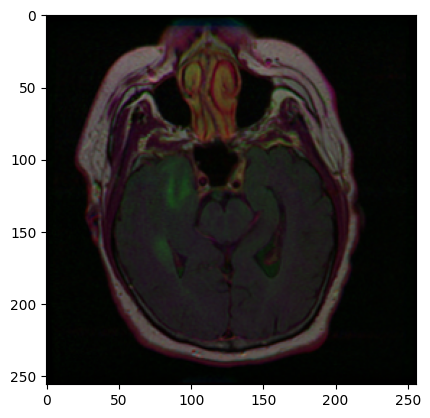

In [ ]:
plt.imshow(cv2.imread(tumor_image_path))

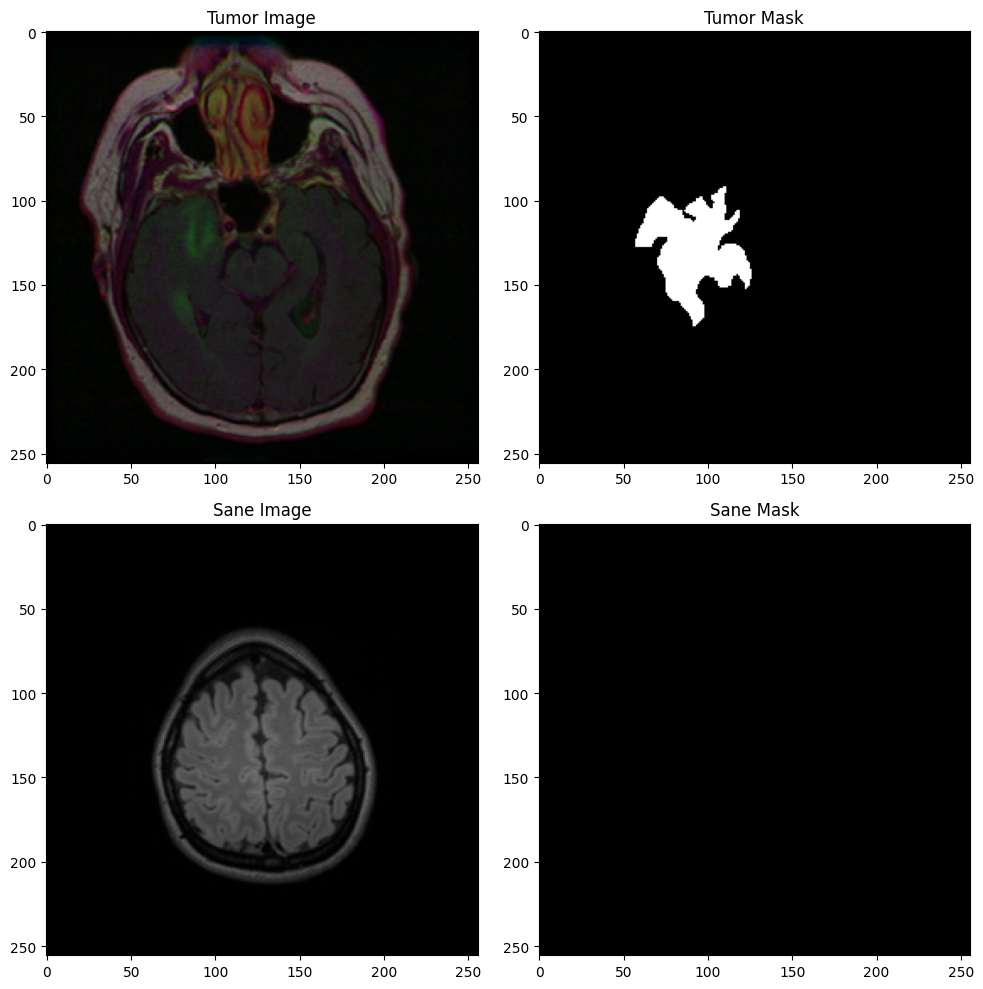

In [ ]:
import matplotlib.pyplot as plt
import cv2

# Define the image paths
paths = [tumor_image_path, tumor_mask_path, sane_image_path, sane_mask_path]

# Create a 2x2 subplot
fig, axs = plt.subplots(2, 2, figsize=(10, 10))

# Iterate over each subplot
for i, ax in enumerate(axs.flat):
    # Read the image
    img = cv2.imread(paths[i])

    # Convert the image from BGR to RGB
    # img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    # Display the image
    ax.imshow(img)

    # Set the title
    if i == 0:
        ax.set_title('Tumor Image')
    elif i == 1:
        ax.set_title('Tumor Mask')
    elif i == 2:
        ax.set_title('Sane Image')
    else:
        ax.set_title('Sane Mask')

# Display the plot
plt.tight_layout()
plt.show()


# DataGenerator class

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

import albumentations as A
from albumentations.pytorch import ToTensorV2

from sklearn.model_selection import train_test_split

In [ ]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

cuda:0


In [ ]:
class BrainMriDataset(Dataset):
    def __init__(self, df, transforms):
        # df contains the paths to all files
        self.df = df
        # transforms is the set of data augmentation operations we use
        self.transforms = transforms

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        image = cv2.imread(self.df.iloc[idx, 1])
        mask = cv2.imread(self.df.iloc[idx, 2], 0)

        augmented = self.transforms(image=image,
                                    mask=mask)

        image = augmented['image'] # Dimension (3, 255, 255)
        mask = augmented['mask']   # Dimension (255, 255)

        # We notice that the image has one more dimension (3 color channels), so we have to one one "artificial" dimension to the mask to match it
        mask = np.expand_dims(mask, axis=0) # Dimension (1, 255, 255)

        return image, mask


In [ ]:
import albumentations as A
from albumentations.pytorch import ToTensorV2

PATCH_SIZE = 256

strong_transforms = A.Compose([
    A.RandomResizedCrop(width = PATCH_SIZE, height = PATCH_SIZE, p=1.0),
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.RandomRotate90(p=0.5),
    A.Transpose(p=0.5),
    A.ShiftScaleRotate(shift_limit=0.01, scale_limit=0.04, rotate_limit=0, p=0.25),

    # Pixels
    A.RandomBrightnessContrast(p=0.5),
    A.RandomGamma(p=0.25),
    A.Emboss(p=0.25),  # replaced A.IAAEmboss with A.Emboss
    A.Blur(p=0.01, blur_limit = 3),

    # Affine
    A.OneOf([
        A.ElasticTransform(p=0.5, alpha=120, sigma=120 * 0.05, alpha_affine=120 * 0.03),
        A.GridDistortion(p=0.5),
        A.OpticalDistortion(p=1, distort_limit=2, shift_limit=0.5)
    ], p=0.8),

    A.Normalize(p=1.0),
    ToTensorV2(),
])

transforms = A.Compose([
    A.Resize(width = PATCH_SIZE, height = PATCH_SIZE, p=1.0),
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.RandomRotate90(p=0.5),
    A.Transpose(p=0.5),
    A.ShiftScaleRotate(shift_limit=0.01, scale_limit=0.04, rotate_limit=0, p=0.25),

    A.Normalize(p=1.0),
    ToTensorV2(),
])


In [ ]:
# Split df into train_df and val_df
train_df, val_df = train_test_split(df, stratify=df.diagnosis, test_size=0.1)
train_df = train_df.reset_index(drop=True)
val_df = val_df.reset_index(drop=True)

# Split train_df into train_df and test_df
train_df, test_df = train_test_split(train_df, stratify=train_df.diagnosis, test_size=0.15)
train_df = train_df.reset_index(drop=True)

#train_df = train_df[:1000]
print(f"Train: {train_df.shape} \nVal: {val_df.shape} \nTest: {test_df.shape}")

Train: (3005, 4) 
Val: (393, 4) 
Test: (531, 4)


In [ ]:
train_dataset = BrainMriDataset(train_df, transforms)
image, mask = train_dataset[0]  # get the first item
print(image.shape, mask.shape)
print(image, mask)

torch.Size([3, 256, 256]) (1, 256, 256)
tensor([[[-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
         [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
         [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
         ...,
         [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
         [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
         [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179]],

        [[-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
         [-2.0357, -2.0357, -2.0182,  ..., -2.0357, -2.0357, -2.0357],
         [-2.0357, -2.0182, -1.9832,  ..., -2.0357, -2.0357, -2.0357],
         ...,
         [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
         [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
         [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357]],

        [[-1.8044, -1.8044, -1.8044,  ..., -1.8044, -1.8044, -1.8044],
     

# Creation of the dataset

In [ ]:
train_dataset = BrainMriDataset(train_df, transforms=transforms)
train_dataloader = DataLoader(train_dataset, batch_size=8, shuffle=True)

val_dataset = BrainMriDataset(val_df, transforms=transforms)
val_dataloader = DataLoader(val_dataset, batch_size=8, shuffle=False)

test_dataset = BrainMriDataset(test_df, transforms=transforms)
test_dataloader = DataLoader(test_dataset, batch_size=8, shuffle=False)

In [ ]:
# Get a batch of training data
images, masks = next(iter(train_dataloader))

print(f'Images batch shape: {images.shape}')
print(f'Masks batch shape: {masks.shape}')

# Optionally, visualize an image and mask from this batch
import matplotlib.pyplot as plt

# Assuming the images are in the PyTorch format (batch_size, channels, height, width)
# and they are single channel (grayscale), you can use the following


Images batch shape: torch.Size([8, 3, 256, 256])
Masks batch shape: torch.Size([8, 1, 256, 256])


In [ ]:
!pip install torchmetrics

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 729.2/729.2 kB 18.8 MB/s eta 0:00:00


# Architecture of the Model

In [ ]:
def double_conv(in_channels, out_channels):
    return nn.Sequential(
        nn.Conv2d(in_channels, out_channels, 3, padding=1),
        nn.ReLU(inplace=True),
        nn.Conv2d(out_channels, out_channels, 3, padding=1),
        nn.ReLU(inplace=True))

In [ ]:
class UNet(nn.Module):

    def __init__(self):
        super().__init__()

        # Define convolutional layers
        # These are used in the "down" path of the U-Net,
        # where the image is successively downsampled
        self.conv_down1 = double_conv(3, 64)
        self.conv_down2 = double_conv(64, 128)
        self.conv_down3 = double_conv(128, 256)
        self.conv_down4 = double_conv(256, 512)

        # Define max pooling layer for downsampling
        self.maxpool = nn.MaxPool2d(2)

        # Define upsampling layer
        self.upsample = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)

        # Define convolutional layers
        # These are used in the "up" path of the U-Net,
        # where the image is successively upsampled
        self.conv_up3 = double_conv(256 + 512, 256)
        self.conv_up2 = double_conv(128 + 256, 128)
        self.conv_up1 = double_conv(128 + 64, 64)

        # Define final convolution to output correct number of classes
        # 1 because there are only two classes (tumor or not tumor)
        self.last_conv = nn.Conv2d(64, 1, kernel_size=1)

    def forward(self, x):
        # Forward pass through the network

        # Down path
        conv1 = self.conv_down1(x)
        x = self.maxpool(conv1)
        conv2 = self.conv_down2(x)
        x = self.maxpool(conv2)
        conv3 = self.conv_down3(x)
        x = self.maxpool(conv3)
        x = self.conv_down4(x)

        # Up path
        x = self.upsample(x)
        x = torch.cat([x, conv3], dim=1)
        x = self.conv_up3(x)
        x = self.upsample(x)
        x = torch.cat([x, conv2], dim=1)
        x = self.conv_up2(x)
        x = self.upsample(x)
        x = torch.cat([x, conv1], dim=1)
        x = self.conv_up1(x)

        # Final output
        out = self.last_conv(x)
        out = torch.sigmoid(out)

        return out


In [ ]:
unet = UNet().to(device)
output = unet(torch.randn(1,3,256,256).to(device))
print("",output.shape)

 torch.Size([1, 1, 256, 256])


In [ ]:
def dice_coef_metric(inputs, target):
    intersection = 2.0 * (target * inputs).sum()
    union = target.sum() + inputs.sum()
    if target.sum() == 0 and inputs.sum() == 0:
        return 1.0

    return intersection / union

In [ ]:
def dice_coef_loss(inputs, target):
    smooth = 1.0
    intersection = 2.0 * ((target * inputs).sum()) + smooth
    union = target.sum() + inputs.sum() + smooth

    return 1 - (intersection / union)


def bce_dice_loss(inputs, target):
    inputs = inputs.float()
    target = target.float()

    dicescore = dice_coef_loss(inputs, target)
    bcescore = nn.BCELoss()
    bceloss = bcescore(inputs, target)

    return bceloss + dicescore

# loss check
bce_dice_loss(torch.tensor([0.7, 1., 1.]),
              torch.tensor([1.,1.,1.]))

tensor(0.1637)

# Training loop

In [ ]:
import logging
import matplotlib.pyplot as plt
from tqdm import tqdm

from torchmetrics.classification import Dice
dice_metric = Dice(average='micro').to(device)

logging.basicConfig(filename='training_log.log', level=logging.INFO)

def train_model(model_name, model, train_loader, val_loader, train_loss, optimizer, lr_scheduler, num_epochs):

    logging.info(model_name)

    train_loss_history = []
    validation_loss_history = []

    train_dice_score_history = []
    validation_dice_score_history = []


    # Create Dice metric instance and move it to the device
    dice_metric = Dice(average='micro').to(device)

    for epoch in range(num_epochs):
        model.train()  # Enter train mode

        current_training_losses = []
        current_training_dice_scores = []


        if lr_scheduler:
            warmup_factor = 1.0 / 100
            warmup_iters = min(100, len(train_loader) - 1)
            lr_scheduler = warmup_lr_scheduler(optimizer, warmup_iters, warmup_factor)

        for i_step, (data, target) in enumerate(tqdm(train_loader, desc=f"Training epoch {epoch+1}/{num_epochs}")):
            data = data.to(device)
            target = target.to(device)

            print("data shape", data.shape)


            outputs = model(data)
            prediction = (outputs > 0.5).detach()


            # Compute Dice coefficient using torchmetrics
            dice_score = dice_metric(prediction, target)


            loss = train_loss(outputs, target)

            current_training_losses.append(loss.item())
            current_training_dice_scores.append(dice_score.item())

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()


            if lr_scheduler:
                lr_scheduler.step()

        # Evaluation on the validation set

        val_dice_score = compute_dice_score(model, val_loader, device)
        validation_dice_score_history.append(val_dice_score)

        train_dice_score = compute_dice_score(model, train_loader, device)
        train_dice_score_history.append(train_dice_score)

        train_loss_history.append(np.mean(current_training_losses))

        logging.info(f"Epoch: {epoch}, Mean loss on train: {np.mean(current_training_losses)}, Mean DICE on train: {np.mean(current_training_dice_scores)}, Mean DICE on validation: {val_dice_score}")

        # Save the model state for resuming training
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': np.mean(current_training_losses),
            'train_dice_score': np.mean(current_training_dice_scores),
            'val_dice_score': val_dice_score
        }, f'{model_name}_checkpoint_{epoch}.pth')

        # Plot the training and validation history
        # Plot the training and validation history
        plt.figure(figsize=(12, 4))
        plt.subplot(1, 2, 1)
        plt.plot(train_loss_history, label='Train Loss')
        plt.plot(validation_dice_score_history, label='Val DICE')
        plt.xlabel('Epochs')
        plt.ylabel('Loss / DICE')
        plt.legend()

        plt.subplot(1, 2, 2)
        plt.plot(train_dice_score_history, label='Train DICE')
        plt.xlabel('Epochs')
        plt.ylabel('DICE')
        plt.legend()

        # Save the figure
        plt.savefig(f'{model_name}_training_plot_epoch_{epoch}.png')
        plt.close()  # Close the figure to free up memory

        # Display the plot in the notebook
        plt.show()


    return train_loss_history, validation_loss_history, train_dice_score_history, validation_dice_score_history


def compute_dice_score(model, loader, device):
    model.eval()
    dice_metric = Dice(average='micro').to(device)
    dice_scores = []
    with torch.no_grad():
        for data, target in loader:
            data = data.to(device)
            target = target.to(device)
            outputs = model(data)

            outputs = torch.argmax(outputs, dim=1).detach()
            dice_scores.append(dice_metric(outputs, target).item())
    return np.mean(dice_scores)





In [ ]:
unet_optimizer = torch.optim.Adamax(unet.parameters(), lr=1e-3)

In [ ]:
# lr_scheduler
def warmup_lr_scheduler(optimizer, warmup_iters, warmup_factor):
    def f(x):
        if x >= warmup_iters:
            return 1
        alpha = float(x) / warmup_iters
        return warmup_factor * (1 - alpha) + alpha

    return torch.optim.lr_scheduler.LambdaLR(optimizer, f)

In [ ]:
%%time
num_ep = 20
# Train UNet
unet_lh, unet_th, unet_vh = train_model("Vanila_UNet", unet, train_dataloader, val_dataloader, bce_dice_loss, unet_optimizer, False, num_epochs = 20)

Training epoch 1/20:   0%|          | 0/376 [00:00<?, ?it/s]

data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 1/20:   0%|          | 1/376 [00:00<02:20,  2.68it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 1/20:   1%|          | 2/376 [00:00<02:36,  2.39it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 1/20:   1%|          | 3/376 [00:01<02:42,  2.30it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 1/20:   1%|          | 4/376 [00:01<02:45,  2.25it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 1/20:   1%|▏         | 5/376 [00:02<02:46,  2.23it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 1/20:   2%|▏         | 6/376 [00:02<02:47,  2.21it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 1/20:   2%|▏         | 7/376 [00:03<02:47,  2.20it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 1/20:   2%|▏         | 8/376 [00:03<02:47,  2.19it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 1/20:   2%|▏         | 9/376 [00:04<02:47,  2.19it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 1/20:   3%|▎         | 10/376 [00:04<02:47,  2.19it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 1/20:   3%|▎         | 11/376 [00:04<02:47,  2.18it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 1/20:   3%|▎         | 12/376 [00:05<02:47,  2.18it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 1/20:   3%|▎         | 13/376 [00:05<02:47,  2.17it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 1/20:   4%|▎         | 14/376 [00:06<02:46,  2.17it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 1/20:   4%|▍         | 15/376 [00:06<02:46,  2.17it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 1/20:   4%|▍         | 16/376 [00:07<02:46,  2.16it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 1/20:   5%|▍         | 17/376 [00:07<02:46,  2.15it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 1/20:   5%|▍         | 18/376 [00:08<02:46,  2.15it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 1/20:   5%|▌         | 19/376 [00:08<02:46,  2.15it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 1/20:   5%|▌         | 20/376 [00:09<02:46,  2.14it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 1/20:   6%|▌         | 21/376 [00:09<02:45,  2.14it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 1/20:   6%|▌         | 22/376 [00:10<02:45,  2.14it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 1/20:   6%|▌         | 23/376 [00:10<02:45,  2.13it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 1/20:   6%|▋         | 24/376 [00:11<02:45,  2.13it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 1/20:   7%|▋         | 25/376 [00:11<02:46,  2.10it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 1/20:   7%|▋         | 26/376 [00:11<02:46,  2.10it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 1/20:   7%|▋         | 27/376 [00:12<02:47,  2.08it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 1/20:   7%|▋         | 28/376 [00:12<02:50,  2.04it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 1/20:   8%|▊         | 29/376 [00:13<02:47,  2.07it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 1/20:   8%|▊         | 30/376 [00:13<02:46,  2.08it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 1/20:   8%|▊         | 31/376 [00:14<02:45,  2.08it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 1/20:   9%|▊         | 32/376 [00:14<02:44,  2.09it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 1/20:   9%|▉         | 33/376 [00:15<02:44,  2.09it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 1/20:   9%|▉         | 34/376 [00:15<02:43,  2.10it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 1/20:   9%|▉         | 35/376 [00:16<02:42,  2.09it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 1/20:  10%|▉         | 36/376 [00:16<02:42,  2.10it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 1/20:  10%|▉         | 37/376 [00:17<02:41,  2.10it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 1/20:  10%|█         | 38/376 [00:17<02:41,  2.10it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 1/20:  10%|█         | 39/376 [00:18<02:41,  2.09it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 1/20:  11%|█         | 40/376 [00:18<02:41,  2.09it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 1/20:  11%|█         | 41/376 [00:19<02:41,  2.08it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 1/20:  11%|█         | 42/376 [00:19<02:40,  2.08it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 1/20:  11%|█▏        | 43/376 [00:20<02:40,  2.08it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 1/20:  12%|█▏        | 44/376 [00:20<02:39,  2.08it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 1/20:  12%|█▏        | 45/376 [00:21<02:39,  2.08it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 1/20:  12%|█▏        | 46/376 [00:21<02:38,  2.08it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 1/20:  12%|█▎        | 47/376 [00:22<02:38,  2.08it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 1/20:  13%|█▎        | 48/376 [00:22<02:37,  2.08it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 1/20:  13%|█▎        | 49/376 [00:23<02:37,  2.07it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 1/20:  13%|█▎        | 50/376 [00:23<02:37,  2.07it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 1/20:  14%|█▎        | 51/376 [00:23<02:35,  2.08it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 1/20:  14%|█▍        | 52/376 [00:24<02:35,  2.08it/s]

dice score tensor(0., device='cuda:0')


Training epoch 1/20:  14%|█▍        | 53/376 [00:24<02:24,  2.23it/s]

data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])
dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 1/20:  14%|█▍        | 54/376 [00:25<02:27,  2.18it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 1/20:  15%|█▍        | 55/376 [00:25<02:28,  2.16it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 1/20:  15%|█▍        | 56/376 [00:26<02:28,  2.15it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 1/20:  15%|█▌        | 57/376 [00:26<02:29,  2.14it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 1/20:  15%|█▌        | 58/376 [00:27<02:29,  2.12it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 1/20:  16%|█▌        | 59/376 [00:27<02:29,  2.12it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 1/20:  16%|█▌        | 60/376 [00:28<02:29,  2.12it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 1/20:  16%|█▌        | 61/376 [00:28<02:28,  2.11it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 1/20:  16%|█▋        | 62/376 [00:29<02:27,  2.12it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 1/20:  17%|█▋        | 63/376 [00:29<02:27,  2.12it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 1/20:  17%|█▋        | 64/376 [00:30<02:27,  2.11it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 1/20:  17%|█▋        | 65/376 [00:30<02:29,  2.08it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 1/20:  18%|█▊        | 66/376 [00:31<02:26,  2.11it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 1/20:  18%|█▊        | 67/376 [00:31<02:25,  2.13it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 1/20:  18%|█▊        | 68/376 [00:31<02:25,  2.12it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 1/20:  18%|█▊        | 69/376 [00:32<02:24,  2.13it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 1/20:  19%|█▊        | 70/376 [00:32<02:26,  2.09it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 1/20:  19%|█▉        | 71/376 [00:33<02:23,  2.13it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 1/20:  19%|█▉        | 72/376 [00:33<02:23,  2.12it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 1/20:  19%|█▉        | 73/376 [00:34<02:24,  2.09it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 1/20:  20%|█▉        | 74/376 [00:34<02:21,  2.13it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 1/20:  20%|█▉        | 75/376 [00:35<02:21,  2.12it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 1/20:  20%|██        | 76/376 [00:35<02:21,  2.12it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 1/20:  20%|██        | 77/376 [00:36<02:20,  2.13it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 1/20:  21%|██        | 78/376 [00:36<02:19,  2.14it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 1/20:  21%|██        | 79/376 [00:37<02:21,  2.09it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 1/20:  21%|██▏       | 80/376 [00:37<02:19,  2.12it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 1/20:  22%|██▏       | 81/376 [00:38<02:20,  2.11it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 1/20:  22%|██▏       | 82/376 [00:38<02:19,  2.10it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 1/20:  22%|██▏       | 83/376 [00:39<02:16,  2.14it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 1/20:  22%|██▏       | 84/376 [00:39<02:15,  2.15it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 1/20:  23%|██▎       | 85/376 [00:39<02:14,  2.16it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 1/20:  23%|██▎       | 86/376 [00:40<02:14,  2.16it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 1/20:  23%|██▎       | 87/376 [00:40<02:13,  2.16it/s]

dice score tensor(0., device='cuda:0')


Training epoch 1/20:  23%|██▎       | 88/376 [00:41<02:03,  2.33it/s]

data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])
dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 1/20:  24%|██▎       | 89/376 [00:41<02:06,  2.26it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 1/20:  24%|██▍       | 90/376 [00:42<02:07,  2.24it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 1/20:  24%|██▍       | 91/376 [00:42<02:08,  2.22it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 1/20:  24%|██▍       | 92/376 [00:43<02:08,  2.21it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 1/20:  25%|██▍       | 93/376 [00:43<02:08,  2.21it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 1/20:  25%|██▌       | 94/376 [00:43<02:08,  2.20it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 1/20:  25%|██▌       | 95/376 [00:44<02:07,  2.20it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 1/20:  26%|██▌       | 96/376 [00:44<02:07,  2.20it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 1/20:  26%|██▌       | 97/376 [00:45<02:06,  2.20it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 1/20:  26%|██▌       | 98/376 [00:45<02:06,  2.20it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 1/20:  26%|██▋       | 99/376 [00:46<02:05,  2.20it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 1/20:  27%|██▋       | 100/376 [00:46<02:05,  2.20it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 1/20:  27%|██▋       | 101/376 [00:47<02:05,  2.20it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 1/20:  27%|██▋       | 102/376 [00:47<02:04,  2.20it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 1/20:  27%|██▋       | 103/376 [00:48<02:03,  2.20it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 1/20:  28%|██▊       | 104/376 [00:48<02:03,  2.21it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 1/20:  28%|██▊       | 105/376 [00:48<02:03,  2.20it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 1/20:  28%|██▊       | 106/376 [00:49<02:02,  2.20it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 1/20:  28%|██▊       | 107/376 [00:49<02:02,  2.20it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 1/20:  29%|██▊       | 108/376 [00:50<02:01,  2.20it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 1/20:  29%|██▉       | 109/376 [00:50<02:00,  2.21it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 1/20:  29%|██▉       | 110/376 [00:51<02:00,  2.21it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 1/20:  30%|██▉       | 111/376 [00:51<02:00,  2.20it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 1/20:  30%|██▉       | 112/376 [00:52<01:59,  2.21it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 1/20:  30%|███       | 113/376 [00:52<01:59,  2.20it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 1/20:  30%|███       | 114/376 [00:53<01:58,  2.21it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 1/20:  31%|███       | 115/376 [00:53<01:57,  2.21it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 1/20:  31%|███       | 116/376 [00:53<01:57,  2.21it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 1/20:  31%|███       | 117/376 [00:54<01:56,  2.22it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 1/20:  31%|███▏      | 118/376 [00:54<01:56,  2.21it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 1/20:  32%|███▏      | 119/376 [00:55<01:56,  2.21it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 1/20:  32%|███▏      | 120/376 [00:55<01:55,  2.21it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 1/20:  32%|███▏      | 121/376 [00:56<01:54,  2.22it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 1/20:  32%|███▏      | 122/376 [00:56<01:54,  2.22it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 1/20:  33%|███▎      | 123/376 [00:57<01:54,  2.22it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 1/20:  33%|███▎      | 124/376 [00:57<01:53,  2.22it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 1/20:  33%|███▎      | 125/376 [00:58<01:53,  2.22it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 1/20:  34%|███▎      | 126/376 [00:58<01:52,  2.22it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 1/20:  34%|███▍      | 127/376 [00:58<01:52,  2.22it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 1/20:  34%|███▍      | 128/376 [00:59<01:51,  2.22it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 1/20:  34%|███▍      | 129/376 [00:59<01:51,  2.22it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 1/20:  35%|███▍      | 130/376 [01:00<01:50,  2.22it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 1/20:  35%|███▍      | 131/376 [01:00<01:50,  2.22it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 1/20:  35%|███▌      | 132/376 [01:01<01:49,  2.23it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 1/20:  35%|███▌      | 133/376 [01:01<01:49,  2.22it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 1/20:  36%|███▌      | 134/376 [01:02<01:48,  2.22it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 1/20:  36%|███▌      | 135/376 [01:02<01:48,  2.22it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 1/20:  36%|███▌      | 136/376 [01:02<01:47,  2.22it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 1/20:  36%|███▋      | 137/376 [01:03<01:47,  2.22it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 1/20:  37%|███▋      | 138/376 [01:03<01:47,  2.22it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 1/20:  37%|███▋      | 139/376 [01:04<01:46,  2.22it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 1/20:  37%|███▋      | 140/376 [01:04<01:46,  2.22it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 1/20:  38%|███▊      | 141/376 [01:05<01:45,  2.22it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 1/20:  38%|███▊      | 142/376 [01:05<01:45,  2.22it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 1/20:  38%|███▊      | 143/376 [01:06<01:45,  2.22it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 1/20:  38%|███▊      | 144/376 [01:06<01:44,  2.22it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 1/20:  39%|███▊      | 145/376 [01:07<01:43,  2.22it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 1/20:  39%|███▉      | 146/376 [01:07<01:43,  2.22it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 1/20:  39%|███▉      | 147/376 [01:07<01:43,  2.22it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 1/20:  39%|███▉      | 148/376 [01:08<01:42,  2.23it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 1/20:  40%|███▉      | 149/376 [01:08<01:42,  2.22it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 1/20:  40%|███▉      | 150/376 [01:09<01:41,  2.23it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 1/20:  40%|████      | 151/376 [01:09<01:41,  2.22it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 1/20:  40%|████      | 152/376 [01:10<01:40,  2.22it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 1/20:  41%|████      | 153/376 [01:10<01:40,  2.23it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 1/20:  41%|████      | 154/376 [01:11<01:39,  2.23it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 1/20:  41%|████      | 155/376 [01:11<01:39,  2.22it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 1/20:  41%|████▏     | 156/376 [01:11<01:39,  2.22it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 1/20:  42%|████▏     | 157/376 [01:12<01:38,  2.22it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 1/20:  42%|████▏     | 158/376 [01:12<01:38,  2.22it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 1/20:  42%|████▏     | 159/376 [01:13<01:37,  2.22it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 1/20:  43%|████▎     | 160/376 [01:13<01:37,  2.22it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 1/20:  43%|████▎     | 161/376 [01:14<01:36,  2.22it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 1/20:  43%|████▎     | 162/376 [01:14<01:36,  2.22it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 1/20:  43%|████▎     | 163/376 [01:15<01:35,  2.22it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 1/20:  44%|████▎     | 164/376 [01:15<01:35,  2.22it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 1/20:  44%|████▍     | 165/376 [01:16<01:35,  2.22it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 1/20:  44%|████▍     | 166/376 [01:16<01:34,  2.22it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 1/20:  44%|████▍     | 167/376 [01:16<01:34,  2.22it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 1/20:  45%|████▍     | 168/376 [01:17<01:33,  2.22it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 1/20:  45%|████▍     | 169/376 [01:17<01:33,  2.21it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 1/20:  45%|████▌     | 170/376 [01:18<01:33,  2.21it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 1/20:  45%|████▌     | 171/376 [01:18<01:32,  2.21it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 1/20:  46%|████▌     | 172/376 [01:19<01:32,  2.21it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 1/20:  46%|████▌     | 173/376 [01:19<01:31,  2.21it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 1/20:  46%|████▋     | 174/376 [01:20<01:31,  2.21it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 1/20:  47%|████▋     | 175/376 [01:20<01:31,  2.21it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 1/20:  47%|████▋     | 176/376 [01:21<01:30,  2.21it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 1/20:  47%|████▋     | 177/376 [01:21<01:29,  2.22it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 1/20:  47%|████▋     | 178/376 [01:21<01:29,  2.21it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 1/20:  48%|████▊     | 179/376 [01:22<01:29,  2.21it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 1/20:  48%|████▊     | 180/376 [01:22<01:28,  2.21it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 1/20:  48%|████▊     | 181/376 [01:23<01:28,  2.21it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 1/20:  48%|████▊     | 182/376 [01:23<01:27,  2.21it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 1/20:  49%|████▊     | 183/376 [01:24<01:27,  2.20it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 1/20:  49%|████▉     | 184/376 [01:24<01:26,  2.21it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 1/20:  49%|████▉     | 185/376 [01:25<01:26,  2.20it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 1/20:  49%|████▉     | 186/376 [01:25<01:26,  2.21it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 1/20:  50%|████▉     | 187/376 [01:25<01:25,  2.21it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 1/20:  50%|█████     | 188/376 [01:26<01:25,  2.21it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 1/20:  50%|█████     | 189/376 [01:26<01:24,  2.21it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 1/20:  51%|█████     | 190/376 [01:27<01:24,  2.21it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 1/20:  51%|█████     | 191/376 [01:27<01:24,  2.20it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 1/20:  51%|█████     | 192/376 [01:28<01:23,  2.20it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 1/20:  51%|█████▏    | 193/376 [01:28<01:23,  2.20it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 1/20:  52%|█████▏    | 194/376 [01:29<01:23,  2.19it/s]

dice score tensor(0., device='cuda:0')


Training epoch 1/20:  52%|█████▏    | 195/376 [01:29<01:16,  2.35it/s]

data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])
dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 1/20:  52%|█████▏    | 196/376 [01:29<01:18,  2.29it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 1/20:  52%|█████▏    | 197/376 [01:30<01:19,  2.26it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 1/20:  53%|█████▎    | 198/376 [01:30<01:19,  2.23it/s]

dice score tensor(0., device='cuda:0')


Training epoch 1/20:  53%|█████▎    | 199/376 [01:31<01:14,  2.37it/s]

data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])
dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 1/20:  53%|█████▎    | 200/376 [01:31<01:16,  2.30it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 1/20:  53%|█████▎    | 201/376 [01:32<01:17,  2.26it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 1/20:  54%|█████▎    | 202/376 [01:32<01:17,  2.23it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 1/20:  54%|█████▍    | 203/376 [01:33<01:17,  2.22it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 1/20:  54%|█████▍    | 204/376 [01:33<01:17,  2.21it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 1/20:  55%|█████▍    | 205/376 [01:34<01:17,  2.21it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 1/20:  55%|█████▍    | 206/376 [01:34<01:17,  2.20it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 1/20:  55%|█████▌    | 207/376 [01:34<01:17,  2.19it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 1/20:  55%|█████▌    | 208/376 [01:35<01:16,  2.19it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 1/20:  56%|█████▌    | 209/376 [01:35<01:16,  2.19it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 1/20:  56%|█████▌    | 210/376 [01:36<01:15,  2.19it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 1/20:  56%|█████▌    | 211/376 [01:36<01:15,  2.19it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 1/20:  56%|█████▋    | 212/376 [01:37<01:14,  2.19it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 1/20:  57%|█████▋    | 213/376 [01:37<01:14,  2.19it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 1/20:  57%|█████▋    | 214/376 [01:38<01:14,  2.19it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 1/20:  57%|█████▋    | 215/376 [01:38<01:13,  2.18it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 1/20:  57%|█████▋    | 216/376 [01:39<01:13,  2.18it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 1/20:  58%|█████▊    | 217/376 [01:39<01:12,  2.18it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 1/20:  58%|█████▊    | 218/376 [01:39<01:12,  2.18it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 1/20:  58%|█████▊    | 219/376 [01:40<01:12,  2.18it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 1/20:  59%|█████▊    | 220/376 [01:40<01:11,  2.18it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 1/20:  59%|█████▉    | 221/376 [01:41<01:11,  2.18it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 1/20:  59%|█████▉    | 222/376 [01:41<01:10,  2.18it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 1/20:  59%|█████▉    | 223/376 [01:42<01:10,  2.18it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 1/20:  60%|█████▉    | 224/376 [01:42<01:09,  2.18it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 1/20:  60%|█████▉    | 225/376 [01:43<01:09,  2.18it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 1/20:  60%|██████    | 226/376 [01:43<01:08,  2.18it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 1/20:  60%|██████    | 227/376 [01:44<01:08,  2.18it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 1/20:  61%|██████    | 228/376 [01:44<01:07,  2.18it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 1/20:  61%|██████    | 229/376 [01:45<01:07,  2.18it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 1/20:  61%|██████    | 230/376 [01:45<01:07,  2.18it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 1/20:  61%|██████▏   | 231/376 [01:45<01:06,  2.17it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 1/20:  62%|██████▏   | 232/376 [01:46<01:06,  2.17it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 1/20:  62%|██████▏   | 233/376 [01:46<01:05,  2.17it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 1/20:  62%|██████▏   | 234/376 [01:47<01:05,  2.17it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 1/20:  62%|██████▎   | 235/376 [01:47<01:05,  2.17it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 1/20:  63%|██████▎   | 236/376 [01:48<01:04,  2.17it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 1/20:  63%|██████▎   | 237/376 [01:48<01:04,  2.17it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 1/20:  63%|██████▎   | 238/376 [01:49<01:03,  2.17it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 1/20:  64%|██████▎   | 239/376 [01:49<01:02,  2.18it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 1/20:  64%|██████▍   | 240/376 [01:50<01:02,  2.18it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 1/20:  64%|██████▍   | 241/376 [01:50<01:02,  2.17it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 1/20:  64%|██████▍   | 242/376 [01:51<01:01,  2.18it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 1/20:  65%|██████▍   | 243/376 [01:51<01:01,  2.17it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 1/20:  65%|██████▍   | 244/376 [01:51<01:00,  2.18it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 1/20:  65%|██████▌   | 245/376 [01:52<01:00,  2.18it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 1/20:  65%|██████▌   | 246/376 [01:52<00:59,  2.18it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 1/20:  66%|██████▌   | 247/376 [01:53<00:59,  2.18it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 1/20:  66%|██████▌   | 248/376 [01:53<00:58,  2.18it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 1/20:  66%|██████▌   | 249/376 [01:54<00:58,  2.18it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 1/20:  66%|██████▋   | 250/376 [01:54<00:57,  2.18it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 1/20:  67%|██████▋   | 251/376 [01:55<00:57,  2.18it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 1/20:  67%|██████▋   | 252/376 [01:55<00:56,  2.18it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 1/20:  67%|██████▋   | 253/376 [01:56<00:56,  2.18it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 1/20:  68%|██████▊   | 254/376 [01:56<00:55,  2.18it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 1/20:  68%|██████▊   | 255/376 [01:56<00:55,  2.18it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 1/20:  68%|██████▊   | 256/376 [01:57<00:54,  2.18it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 1/20:  68%|██████▊   | 257/376 [01:57<00:54,  2.18it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 1/20:  69%|██████▊   | 258/376 [01:58<00:54,  2.18it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 1/20:  69%|██████▉   | 259/376 [01:58<00:53,  2.19it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 1/20:  69%|██████▉   | 260/376 [01:59<00:52,  2.19it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 1/20:  69%|██████▉   | 261/376 [01:59<00:52,  2.18it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 1/20:  70%|██████▉   | 262/376 [02:00<00:52,  2.18it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 1/20:  70%|██████▉   | 263/376 [02:00<00:51,  2.18it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 1/20:  70%|███████   | 264/376 [02:01<00:51,  2.18it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 1/20:  70%|███████   | 265/376 [02:01<00:50,  2.19it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 1/20:  71%|███████   | 266/376 [02:01<00:50,  2.18it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 1/20:  71%|███████   | 267/376 [02:02<00:49,  2.19it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 1/20:  71%|███████▏  | 268/376 [02:02<00:49,  2.18it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 1/20:  72%|███████▏  | 269/376 [02:03<00:48,  2.19it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 1/20:  72%|███████▏  | 270/376 [02:03<00:48,  2.19it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 1/20:  72%|███████▏  | 271/376 [02:04<00:47,  2.19it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 1/20:  72%|███████▏  | 272/376 [02:04<00:47,  2.19it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 1/20:  73%|███████▎  | 273/376 [02:05<00:47,  2.19it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 1/20:  73%|███████▎  | 274/376 [02:05<00:46,  2.19it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 1/20:  73%|███████▎  | 275/376 [02:06<00:45,  2.20it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 1/20:  73%|███████▎  | 276/376 [02:06<00:45,  2.20it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 1/20:  74%|███████▎  | 277/376 [02:07<00:45,  2.20it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 1/20:  74%|███████▍  | 278/376 [02:07<00:44,  2.19it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 1/20:  74%|███████▍  | 279/376 [02:07<00:44,  2.20it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 1/20:  74%|███████▍  | 280/376 [02:08<00:43,  2.19it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 1/20:  75%|███████▍  | 281/376 [02:08<00:43,  2.20it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 1/20:  75%|███████▌  | 282/376 [02:09<00:42,  2.20it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 1/20:  75%|███████▌  | 283/376 [02:09<00:42,  2.20it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 1/20:  76%|███████▌  | 284/376 [02:10<00:41,  2.20it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 1/20:  76%|███████▌  | 285/376 [02:10<00:41,  2.20it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 1/20:  76%|███████▌  | 286/376 [02:11<00:40,  2.20it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 1/20:  76%|███████▋  | 287/376 [02:11<00:40,  2.19it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 1/20:  77%|███████▋  | 288/376 [02:12<00:40,  2.20it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 1/20:  77%|███████▋  | 289/376 [02:12<00:39,  2.20it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 1/20:  77%|███████▋  | 290/376 [02:12<00:39,  2.20it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 1/20:  77%|███████▋  | 291/376 [02:13<00:38,  2.20it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 1/20:  78%|███████▊  | 292/376 [02:13<00:38,  2.20it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 1/20:  78%|███████▊  | 293/376 [02:14<00:37,  2.20it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 1/20:  78%|███████▊  | 294/376 [02:14<00:37,  2.20it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 1/20:  78%|███████▊  | 295/376 [02:15<00:37,  2.18it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 1/20:  79%|███████▊  | 296/376 [02:15<00:36,  2.19it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 1/20:  79%|███████▉  | 297/376 [02:16<00:35,  2.20it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 1/20:  79%|███████▉  | 298/376 [02:16<00:35,  2.20it/s]

dice score tensor(0., device='cuda:0')


Training epoch 1/20:  80%|███████▉  | 299/376 [02:16<00:32,  2.35it/s]

data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])
dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 1/20:  80%|███████▉  | 300/376 [02:17<00:33,  2.28it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 1/20:  80%|████████  | 301/376 [02:17<00:33,  2.26it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 1/20:  80%|████████  | 302/376 [02:18<00:33,  2.24it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 1/20:  81%|████████  | 303/376 [02:18<00:32,  2.23it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 1/20:  81%|████████  | 304/376 [02:19<00:32,  2.22it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 1/20:  81%|████████  | 305/376 [02:19<00:32,  2.22it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 1/20:  81%|████████▏ | 306/376 [02:20<00:31,  2.21it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 1/20:  82%|████████▏ | 307/376 [02:20<00:31,  2.21it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 1/20:  82%|████████▏ | 308/376 [02:21<00:30,  2.21it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 1/20:  82%|████████▏ | 309/376 [02:21<00:30,  2.20it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 1/20:  82%|████████▏ | 310/376 [02:21<00:29,  2.20it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 1/20:  83%|████████▎ | 311/376 [02:22<00:29,  2.21it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 1/20:  83%|████████▎ | 312/376 [02:22<00:29,  2.21it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 1/20:  83%|████████▎ | 313/376 [02:23<00:28,  2.20it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 1/20:  84%|████████▎ | 314/376 [02:23<00:28,  2.20it/s]

dice score tensor(0., device='cuda:0')


Training epoch 1/20:  84%|████████▍ | 315/376 [02:24<00:25,  2.36it/s]

data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])
dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 1/20:  84%|████████▍ | 316/376 [02:24<00:26,  2.29it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 1/20:  84%|████████▍ | 317/376 [02:25<00:26,  2.26it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 1/20:  85%|████████▍ | 318/376 [02:25<00:25,  2.24it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 1/20:  85%|████████▍ | 319/376 [02:25<00:25,  2.23it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 1/20:  85%|████████▌ | 320/376 [02:26<00:25,  2.22it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 1/20:  85%|████████▌ | 321/376 [02:26<00:24,  2.21it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 1/20:  86%|████████▌ | 322/376 [02:27<00:24,  2.21it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 1/20:  86%|████████▌ | 323/376 [02:27<00:24,  2.21it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 1/20:  86%|████████▌ | 324/376 [02:28<00:23,  2.20it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 1/20:  86%|████████▋ | 325/376 [02:28<00:23,  2.20it/s]

dice score tensor(0., device='cuda:0')


Training epoch 1/20:  87%|████████▋ | 326/376 [02:29<00:21,  2.35it/s]

data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])
dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 1/20:  87%|████████▋ | 327/376 [02:29<00:21,  2.29it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 1/20:  87%|████████▋ | 328/376 [02:29<00:21,  2.25it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 1/20:  88%|████████▊ | 329/376 [02:30<00:21,  2.23it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 1/20:  88%|████████▊ | 330/376 [02:30<00:20,  2.22it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 1/20:  88%|████████▊ | 331/376 [02:31<00:20,  2.21it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 1/20:  88%|████████▊ | 332/376 [02:31<00:19,  2.20it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 1/20:  89%|████████▊ | 333/376 [02:32<00:19,  2.21it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 1/20:  89%|████████▉ | 334/376 [02:32<00:19,  2.21it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 1/20:  89%|████████▉ | 335/376 [02:33<00:18,  2.20it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 1/20:  89%|████████▉ | 336/376 [02:33<00:18,  2.20it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 1/20:  90%|████████▉ | 337/376 [02:34<00:17,  2.20it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 1/20:  90%|████████▉ | 338/376 [02:34<00:17,  2.20it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 1/20:  90%|█████████ | 339/376 [02:34<00:16,  2.20it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 1/20:  90%|█████████ | 340/376 [02:35<00:16,  2.20it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 1/20:  91%|█████████ | 341/376 [02:35<00:15,  2.20it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 1/20:  91%|█████████ | 342/376 [02:36<00:15,  2.20it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 1/20:  91%|█████████ | 343/376 [02:36<00:15,  2.20it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 1/20:  91%|█████████▏| 344/376 [02:37<00:14,  2.20it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 1/20:  92%|█████████▏| 345/376 [02:37<00:14,  2.19it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 1/20:  92%|█████████▏| 346/376 [02:38<00:13,  2.19it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 1/20:  92%|█████████▏| 347/376 [02:38<00:13,  2.19it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 1/20:  93%|█████████▎| 348/376 [02:39<00:12,  2.19it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 1/20:  93%|█████████▎| 349/376 [02:39<00:12,  2.20it/s]

dice score tensor(0., device='cuda:0')


Training epoch 1/20:  93%|█████████▎| 350/376 [02:39<00:11,  2.35it/s]

data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])
dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 1/20:  93%|█████████▎| 351/376 [02:40<00:10,  2.28it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 1/20:  94%|█████████▎| 352/376 [02:40<00:10,  2.25it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 1/20:  94%|█████████▍| 353/376 [02:41<00:10,  2.23it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 1/20:  94%|█████████▍| 354/376 [02:41<00:09,  2.22it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 1/20:  94%|█████████▍| 355/376 [02:42<00:09,  2.21it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 1/20:  95%|█████████▍| 356/376 [02:42<00:09,  2.20it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 1/20:  95%|█████████▍| 357/376 [02:43<00:08,  2.20it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 1/20:  95%|█████████▌| 358/376 [02:43<00:08,  2.19it/s]

dice score tensor(0., device='cuda:0')


Training epoch 1/20:  95%|█████████▌| 359/376 [02:43<00:07,  2.34it/s]

data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])
dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 1/20:  96%|█████████▌| 360/376 [02:44<00:07,  2.28it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 1/20:  96%|█████████▌| 361/376 [02:44<00:06,  2.25it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 1/20:  96%|█████████▋| 362/376 [02:45<00:06,  2.22it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 1/20:  97%|█████████▋| 363/376 [02:45<00:05,  2.21it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 1/20:  97%|█████████▋| 364/376 [02:46<00:05,  2.20it/s]

dice score tensor(0., device='cuda:0')


Training epoch 1/20:  97%|█████████▋| 365/376 [02:46<00:04,  2.36it/s]

data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])
dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 1/20:  97%|█████████▋| 366/376 [02:47<00:04,  2.28it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 1/20:  98%|█████████▊| 367/376 [02:47<00:03,  2.25it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 1/20:  98%|█████████▊| 368/376 [02:47<00:03,  2.23it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 1/20:  98%|█████████▊| 369/376 [02:48<00:03,  2.22it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 1/20:  98%|█████████▊| 370/376 [02:48<00:02,  2.20it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 1/20:  99%|█████████▊| 371/376 [02:49<00:02,  2.20it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 1/20:  99%|█████████▉| 372/376 [02:49<00:01,  2.19it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 1/20:  99%|█████████▉| 373/376 [02:50<00:01,  2.19it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 1/20:  99%|█████████▉| 374/376 [02:50<00:00,  2.19it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 1/20: 100%|█████████▉| 375/376 [02:51<00:00,  2.19it/s]

dice score tensor(0., device='cuda:0')


Training epoch 1/20: 100%|██████████| 376/376 [02:51<00:00,  2.19it/s]

data shape torch.Size([5, 3, 256, 256])
target shape torch.Size([5, 1, 256, 256])
prediction shape torch.Size([5, 1, 256, 256])
dice score tensor(0., device='cuda:0')



Training epoch 2/20:   0%|          | 0/376 [00:00<?, ?it/s]

data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 2/20:   0%|          | 1/376 [00:00<01:47,  3.50it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 2/20:   1%|          | 2/376 [00:00<02:20,  2.66it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 2/20:   1%|          | 3/376 [00:01<02:33,  2.44it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 2/20:   1%|          | 4/376 [00:01<02:37,  2.37it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 2/20:   1%|▏         | 5/376 [00:02<02:40,  2.31it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 2/20:   2%|▏         | 6/376 [00:02<02:41,  2.29it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 2/20:   2%|▏         | 7/376 [00:02<02:41,  2.28it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 2/20:   2%|▏         | 8/376 [00:03<02:41,  2.27it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 2/20:   2%|▏         | 9/376 [00:03<02:41,  2.27it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 2/20:   3%|▎         | 10/376 [00:04<02:41,  2.26it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 2/20:   3%|▎         | 11/376 [00:04<02:41,  2.26it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 2/20:   3%|▎         | 12/376 [00:05<02:41,  2.25it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 2/20:   3%|▎         | 13/376 [00:05<02:41,  2.25it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 2/20:   4%|▎         | 14/376 [00:06<02:40,  2.25it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 2/20:   4%|▍         | 15/376 [00:06<02:40,  2.26it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 2/20:   4%|▍         | 16/376 [00:06<02:39,  2.26it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 2/20:   5%|▍         | 17/376 [00:07<02:39,  2.25it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 2/20:   5%|▍         | 18/376 [00:07<02:38,  2.25it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 2/20:   5%|▌         | 19/376 [00:08<02:38,  2.25it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 2/20:   5%|▌         | 20/376 [00:08<02:38,  2.25it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 2/20:   6%|▌         | 21/376 [00:09<02:37,  2.25it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 2/20:   6%|▌         | 22/376 [00:09<02:37,  2.25it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 2/20:   6%|▌         | 23/376 [00:10<02:37,  2.24it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 2/20:   6%|▋         | 24/376 [00:10<02:36,  2.25it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 2/20:   7%|▋         | 25/376 [00:10<02:35,  2.25it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 2/20:   7%|▋         | 26/376 [00:11<02:35,  2.26it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 2/20:   7%|▋         | 27/376 [00:11<02:34,  2.26it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 2/20:   7%|▋         | 28/376 [00:12<02:34,  2.26it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 2/20:   8%|▊         | 29/376 [00:12<02:33,  2.26it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 2/20:   8%|▊         | 30/376 [00:13<02:33,  2.26it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 2/20:   8%|▊         | 31/376 [00:13<02:33,  2.25it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 2/20:   9%|▊         | 32/376 [00:14<02:32,  2.25it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 2/20:   9%|▉         | 33/376 [00:14<02:32,  2.25it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 2/20:   9%|▉         | 34/376 [00:14<02:32,  2.25it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 2/20:   9%|▉         | 35/376 [00:15<02:31,  2.25it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 2/20:  10%|▉         | 36/376 [00:15<02:31,  2.24it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 2/20:  10%|▉         | 37/376 [00:16<02:31,  2.24it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 2/20:  10%|█         | 38/376 [00:16<02:30,  2.24it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 2/20:  10%|█         | 39/376 [00:17<02:30,  2.25it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 2/20:  11%|█         | 40/376 [00:17<02:29,  2.24it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 2/20:  11%|█         | 41/376 [00:18<02:28,  2.25it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 2/20:  11%|█         | 42/376 [00:18<02:28,  2.25it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 2/20:  11%|█▏        | 43/376 [00:18<02:28,  2.25it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 2/20:  12%|█▏        | 44/376 [00:19<02:27,  2.25it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 2/20:  12%|█▏        | 45/376 [00:19<02:27,  2.24it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 2/20:  12%|█▏        | 46/376 [00:20<02:26,  2.25it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 2/20:  12%|█▎        | 47/376 [00:20<02:26,  2.25it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 2/20:  13%|█▎        | 48/376 [00:21<02:25,  2.25it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 2/20:  13%|█▎        | 49/376 [00:21<02:25,  2.25it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 2/20:  13%|█▎        | 50/376 [00:22<02:24,  2.25it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 2/20:  14%|█▎        | 51/376 [00:22<02:24,  2.25it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 2/20:  14%|█▍        | 52/376 [00:22<02:23,  2.25it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 2/20:  14%|█▍        | 53/376 [00:23<02:23,  2.25it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 2/20:  14%|█▍        | 54/376 [00:23<02:22,  2.25it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 2/20:  15%|█▍        | 55/376 [00:24<02:22,  2.25it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 2/20:  15%|█▍        | 56/376 [00:24<02:22,  2.25it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 2/20:  15%|█▌        | 57/376 [00:25<02:21,  2.25it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 2/20:  15%|█▌        | 58/376 [00:25<02:21,  2.25it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 2/20:  16%|█▌        | 59/376 [00:26<02:20,  2.25it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 2/20:  16%|█▌        | 60/376 [00:26<02:20,  2.25it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 2/20:  16%|█▌        | 61/376 [00:26<02:20,  2.25it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 2/20:  16%|█▋        | 62/376 [00:27<02:19,  2.25it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 2/20:  17%|█▋        | 63/376 [00:27<02:19,  2.24it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 2/20:  17%|█▋        | 64/376 [00:28<02:19,  2.24it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 2/20:  17%|█▋        | 65/376 [00:28<02:18,  2.25it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 2/20:  18%|█▊        | 66/376 [00:29<02:18,  2.24it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 2/20:  18%|█▊        | 67/376 [00:29<02:17,  2.25it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 2/20:  18%|█▊        | 68/376 [00:30<02:17,  2.24it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 2/20:  18%|█▊        | 69/376 [00:30<02:16,  2.25it/s]

dice score tensor(0., device='cuda:0')


Training epoch 2/20:  19%|█▊        | 70/376 [00:30<02:07,  2.40it/s]

data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])
dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 2/20:  19%|█▉        | 71/376 [00:31<02:10,  2.34it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 2/20:  19%|█▉        | 72/376 [00:31<02:12,  2.30it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 2/20:  19%|█▉        | 73/376 [00:32<02:13,  2.28it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 2/20:  20%|█▉        | 74/376 [00:32<02:13,  2.27it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 2/20:  20%|█▉        | 75/376 [00:33<02:12,  2.26it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 2/20:  20%|██        | 76/376 [00:33<02:12,  2.26it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 2/20:  20%|██        | 77/376 [00:34<02:12,  2.25it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 2/20:  21%|██        | 78/376 [00:34<02:12,  2.26it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 2/20:  21%|██        | 79/376 [00:34<02:11,  2.25it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 2/20:  21%|██▏       | 80/376 [00:35<02:11,  2.25it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 2/20:  22%|██▏       | 81/376 [00:35<02:11,  2.25it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 2/20:  22%|██▏       | 82/376 [00:36<02:10,  2.25it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 2/20:  22%|██▏       | 83/376 [00:36<02:10,  2.25it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 2/20:  22%|██▏       | 84/376 [00:37<02:09,  2.25it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 2/20:  23%|██▎       | 85/376 [00:37<02:09,  2.25it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 2/20:  23%|██▎       | 86/376 [00:38<02:09,  2.24it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 2/20:  23%|██▎       | 87/376 [00:38<02:08,  2.25it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 2/20:  23%|██▎       | 88/376 [00:38<02:08,  2.25it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 2/20:  24%|██▎       | 89/376 [00:39<02:07,  2.25it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 2/20:  24%|██▍       | 90/376 [00:39<02:07,  2.25it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 2/20:  24%|██▍       | 91/376 [00:40<02:06,  2.25it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 2/20:  24%|██▍       | 92/376 [00:40<02:06,  2.25it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 2/20:  25%|██▍       | 93/376 [00:41<02:06,  2.24it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 2/20:  25%|██▌       | 94/376 [00:41<02:05,  2.24it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 2/20:  25%|██▌       | 95/376 [00:42<02:05,  2.25it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 2/20:  26%|██▌       | 96/376 [00:42<02:04,  2.24it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 2/20:  26%|██▌       | 97/376 [00:42<02:04,  2.24it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 2/20:  26%|██▌       | 98/376 [00:43<02:03,  2.24it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 2/20:  26%|██▋       | 99/376 [00:43<02:03,  2.25it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 2/20:  27%|██▋       | 100/376 [00:44<02:03,  2.24it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 2/20:  27%|██▋       | 101/376 [00:44<02:02,  2.24it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 2/20:  27%|██▋       | 102/376 [00:45<02:02,  2.24it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 2/20:  27%|██▋       | 103/376 [00:45<02:01,  2.24it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 2/20:  28%|██▊       | 104/376 [00:46<02:01,  2.24it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 2/20:  28%|██▊       | 105/376 [00:46<02:00,  2.24it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 2/20:  28%|██▊       | 106/376 [00:46<02:00,  2.24it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 2/20:  28%|██▊       | 107/376 [00:47<02:00,  2.24it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 2/20:  29%|██▊       | 108/376 [00:47<01:59,  2.24it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 2/20:  29%|██▉       | 109/376 [00:48<01:59,  2.24it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 2/20:  29%|██▉       | 110/376 [00:48<01:58,  2.25it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 2/20:  30%|██▉       | 111/376 [00:49<01:58,  2.24it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 2/20:  30%|██▉       | 112/376 [00:49<01:57,  2.25it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 2/20:  30%|███       | 113/376 [00:50<01:57,  2.25it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 2/20:  30%|███       | 114/376 [00:50<01:56,  2.24it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 2/20:  31%|███       | 115/376 [00:50<01:56,  2.25it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 2/20:  31%|███       | 116/376 [00:51<01:55,  2.25it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 2/20:  31%|███       | 117/376 [00:51<01:55,  2.25it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 2/20:  31%|███▏      | 118/376 [00:52<01:54,  2.24it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 2/20:  32%|███▏      | 119/376 [00:52<01:54,  2.24it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 2/20:  32%|███▏      | 120/376 [00:53<01:53,  2.25it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 2/20:  32%|███▏      | 121/376 [00:53<01:53,  2.24it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 2/20:  32%|███▏      | 122/376 [00:54<01:53,  2.24it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 2/20:  33%|███▎      | 123/376 [00:54<01:52,  2.24it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 2/20:  33%|███▎      | 124/376 [00:54<01:52,  2.24it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 2/20:  33%|███▎      | 125/376 [00:55<01:52,  2.24it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 2/20:  34%|███▎      | 126/376 [00:55<01:51,  2.24it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 2/20:  34%|███▍      | 127/376 [00:56<01:50,  2.24it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 2/20:  34%|███▍      | 128/376 [00:56<01:50,  2.24it/s]

dice score tensor(0., device='cuda:0')


Training epoch 2/20:  34%|███▍      | 129/376 [00:57<01:42,  2.40it/s]

data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])
dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 2/20:  35%|███▍      | 130/376 [00:57<01:45,  2.33it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 2/20:  35%|███▍      | 131/376 [00:57<01:46,  2.31it/s]

dice score tensor(0., device='cuda:0')


Training epoch 2/20:  35%|███▌      | 132/376 [00:58<01:39,  2.45it/s]

data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])
dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 2/20:  35%|███▌      | 133/376 [00:58<01:43,  2.35it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 2/20:  36%|███▌      | 134/376 [00:59<01:44,  2.31it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 2/20:  36%|███▌      | 135/376 [00:59<01:45,  2.28it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 2/20:  36%|███▌      | 136/376 [01:00<01:45,  2.27it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 2/20:  36%|███▋      | 137/376 [01:00<01:45,  2.26it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 2/20:  37%|███▋      | 138/376 [01:01<01:45,  2.25it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 2/20:  37%|███▋      | 139/376 [01:01<01:45,  2.25it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 2/20:  37%|███▋      | 140/376 [01:01<01:45,  2.24it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 2/20:  38%|███▊      | 141/376 [01:02<01:44,  2.24it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 2/20:  38%|███▊      | 142/376 [01:02<01:45,  2.23it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 2/20:  38%|███▊      | 143/376 [01:03<01:44,  2.23it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 2/20:  38%|███▊      | 144/376 [01:03<01:43,  2.24it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 2/20:  39%|███▊      | 145/376 [01:04<01:43,  2.24it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 2/20:  39%|███▉      | 146/376 [01:04<01:42,  2.24it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 2/20:  39%|███▉      | 147/376 [01:05<01:42,  2.23it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 2/20:  39%|███▉      | 148/376 [01:05<01:41,  2.24it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 2/20:  40%|███▉      | 149/376 [01:05<01:40,  2.25it/s]

dice score tensor(0., device='cuda:0')


Training epoch 2/20:  40%|███▉      | 150/376 [01:06<01:34,  2.40it/s]

data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])
dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 2/20:  40%|████      | 151/376 [01:06<01:36,  2.33it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 2/20:  40%|████      | 152/376 [01:07<01:37,  2.29it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 2/20:  41%|████      | 153/376 [01:07<01:37,  2.28it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 2/20:  41%|████      | 154/376 [01:08<01:37,  2.27it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 2/20:  41%|████      | 155/376 [01:08<01:37,  2.26it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 2/20:  41%|████▏     | 156/376 [01:08<01:37,  2.25it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 2/20:  42%|████▏     | 157/376 [01:09<01:37,  2.25it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 2/20:  42%|████▏     | 158/376 [01:09<01:37,  2.24it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 2/20:  42%|████▏     | 159/376 [01:10<01:36,  2.24it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 2/20:  43%|████▎     | 160/376 [01:10<01:36,  2.24it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 2/20:  43%|████▎     | 161/376 [01:11<01:36,  2.24it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 2/20:  43%|████▎     | 162/376 [01:11<01:35,  2.24it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 2/20:  43%|████▎     | 163/376 [01:12<01:35,  2.24it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 2/20:  44%|████▎     | 164/376 [01:12<01:34,  2.24it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 2/20:  44%|████▍     | 165/376 [01:13<01:34,  2.23it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 2/20:  44%|████▍     | 166/376 [01:13<01:34,  2.23it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 2/20:  44%|████▍     | 167/376 [01:13<01:33,  2.23it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 2/20:  45%|████▍     | 168/376 [01:14<01:33,  2.23it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 2/20:  45%|████▍     | 169/376 [01:14<01:32,  2.23it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 2/20:  45%|████▌     | 170/376 [01:15<01:32,  2.23it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 2/20:  45%|████▌     | 171/376 [01:15<01:32,  2.22it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 2/20:  46%|████▌     | 172/376 [01:16<01:31,  2.22it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 2/20:  46%|████▌     | 173/376 [01:16<01:31,  2.22it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 2/20:  46%|████▋     | 174/376 [01:17<01:30,  2.23it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 2/20:  47%|████▋     | 175/376 [01:17<01:30,  2.23it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 2/20:  47%|████▋     | 176/376 [01:17<01:29,  2.23it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 2/20:  47%|████▋     | 177/376 [01:18<01:29,  2.23it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 2/20:  47%|████▋     | 178/376 [01:18<01:28,  2.23it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 2/20:  48%|████▊     | 179/376 [01:19<01:28,  2.23it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 2/20:  48%|████▊     | 180/376 [01:19<01:27,  2.23it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 2/20:  48%|████▊     | 181/376 [01:20<01:27,  2.24it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 2/20:  48%|████▊     | 182/376 [01:20<01:26,  2.24it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 2/20:  49%|████▊     | 183/376 [01:21<01:26,  2.23it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 2/20:  49%|████▉     | 184/376 [01:21<01:25,  2.24it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 2/20:  49%|████▉     | 185/376 [01:21<01:25,  2.23it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 2/20:  49%|████▉     | 186/376 [01:22<01:25,  2.23it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 2/20:  50%|████▉     | 187/376 [01:22<01:24,  2.23it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 2/20:  50%|█████     | 188/376 [01:23<01:24,  2.23it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 2/20:  50%|█████     | 189/376 [01:23<01:23,  2.23it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 2/20:  51%|█████     | 190/376 [01:24<01:23,  2.23it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 2/20:  51%|█████     | 191/376 [01:24<01:22,  2.23it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 2/20:  51%|█████     | 192/376 [01:25<01:22,  2.23it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 2/20:  51%|█████▏    | 193/376 [01:25<01:22,  2.23it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 2/20:  52%|█████▏    | 194/376 [01:26<01:21,  2.23it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 2/20:  52%|█████▏    | 195/376 [01:26<01:21,  2.23it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 2/20:  52%|█████▏    | 196/376 [01:26<01:20,  2.23it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 2/20:  52%|█████▏    | 197/376 [01:27<01:20,  2.23it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 2/20:  53%|█████▎    | 198/376 [01:27<01:19,  2.23it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 2/20:  53%|█████▎    | 199/376 [01:28<01:19,  2.23it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 2/20:  53%|█████▎    | 200/376 [01:28<01:19,  2.23it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 2/20:  53%|█████▎    | 201/376 [01:29<01:18,  2.23it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 2/20:  54%|█████▎    | 202/376 [01:29<01:18,  2.22it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 2/20:  54%|█████▍    | 203/376 [01:30<01:17,  2.22it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 2/20:  54%|█████▍    | 204/376 [01:30<01:17,  2.22it/s]

dice score tensor(0., device='cuda:0')


Training epoch 2/20:  55%|█████▍    | 205/376 [01:30<01:12,  2.37it/s]

data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])
dice score tensor(0., device='cuda:0')


Training epoch 2/20:  55%|█████▍    | 206/376 [01:31<01:08,  2.47it/s]

data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])
dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 2/20:  55%|█████▌    | 207/376 [01:31<01:10,  2.38it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 2/20:  55%|█████▌    | 208/376 [01:32<01:12,  2.33it/s]

dice score tensor(0., device='cuda:0')


Training epoch 2/20:  56%|█████▌    | 209/376 [01:32<01:07,  2.47it/s]

data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])
dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 2/20:  56%|█████▌    | 210/376 [01:32<01:09,  2.37it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 2/20:  56%|█████▌    | 211/376 [01:33<01:10,  2.33it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 2/20:  56%|█████▋    | 212/376 [01:33<01:11,  2.30it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 2/20:  57%|█████▋    | 213/376 [01:34<01:11,  2.28it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 2/20:  57%|█████▋    | 214/376 [01:34<01:11,  2.26it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 2/20:  57%|█████▋    | 215/376 [01:35<01:11,  2.26it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 2/20:  57%|█████▋    | 216/376 [01:35<01:11,  2.25it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 2/20:  58%|█████▊    | 217/376 [01:36<01:10,  2.25it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 2/20:  58%|█████▊    | 218/376 [01:36<01:10,  2.24it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 2/20:  58%|█████▊    | 219/376 [01:36<01:10,  2.24it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 2/20:  59%|█████▊    | 220/376 [01:37<01:09,  2.24it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 2/20:  59%|█████▉    | 221/376 [01:37<01:09,  2.23it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 2/20:  59%|█████▉    | 222/376 [01:38<01:08,  2.24it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 2/20:  59%|█████▉    | 223/376 [01:38<01:08,  2.23it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 2/20:  60%|█████▉    | 224/376 [01:39<01:08,  2.23it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 2/20:  60%|█████▉    | 225/376 [01:39<01:07,  2.24it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 2/20:  60%|██████    | 226/376 [01:40<01:07,  2.24it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 2/20:  60%|██████    | 227/376 [01:40<01:06,  2.24it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 2/20:  61%|██████    | 228/376 [01:41<01:06,  2.24it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 2/20:  61%|██████    | 229/376 [01:41<01:05,  2.23it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 2/20:  61%|██████    | 230/376 [01:41<01:05,  2.23it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 2/20:  61%|██████▏   | 231/376 [01:42<01:05,  2.23it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 2/20:  62%|██████▏   | 232/376 [01:42<01:04,  2.23it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 2/20:  62%|██████▏   | 233/376 [01:43<01:04,  2.23it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 2/20:  62%|██████▏   | 234/376 [01:43<01:03,  2.23it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 2/20:  62%|██████▎   | 235/376 [01:44<01:03,  2.23it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 2/20:  63%|██████▎   | 236/376 [01:44<01:02,  2.22it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 2/20:  63%|██████▎   | 237/376 [01:45<01:02,  2.23it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 2/20:  63%|██████▎   | 238/376 [01:45<01:02,  2.22it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 2/20:  64%|██████▎   | 239/376 [01:45<01:01,  2.23it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 2/20:  64%|██████▍   | 240/376 [01:46<01:00,  2.23it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 2/20:  64%|██████▍   | 241/376 [01:46<01:00,  2.23it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 2/20:  64%|██████▍   | 242/376 [01:47<01:00,  2.23it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 2/20:  65%|██████▍   | 243/376 [01:47<00:59,  2.23it/s]

dice score tensor(0., device='cuda:0')


Training epoch 2/20:  65%|██████▍   | 244/376 [01:48<00:55,  2.39it/s]

data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])
dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 2/20:  65%|██████▌   | 245/376 [01:48<00:56,  2.33it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 2/20:  65%|██████▌   | 246/376 [01:49<00:56,  2.29it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 2/20:  66%|██████▌   | 247/376 [01:49<00:56,  2.28it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 2/20:  66%|██████▌   | 248/376 [01:49<00:56,  2.27it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 2/20:  66%|██████▌   | 249/376 [01:50<00:56,  2.26it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 2/20:  66%|██████▋   | 250/376 [01:50<00:55,  2.25it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 2/20:  67%|██████▋   | 251/376 [01:51<00:55,  2.25it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 2/20:  67%|██████▋   | 252/376 [01:51<00:55,  2.24it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 2/20:  67%|██████▋   | 253/376 [01:52<00:54,  2.24it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 2/20:  68%|██████▊   | 254/376 [01:52<00:54,  2.24it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 2/20:  68%|██████▊   | 255/376 [01:53<00:54,  2.24it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 2/20:  68%|██████▊   | 256/376 [01:53<00:53,  2.24it/s]

dice score tensor(0., device='cuda:0')


Training epoch 2/20:  68%|██████▊   | 257/376 [01:53<00:49,  2.40it/s]

data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])
dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 2/20:  69%|██████▊   | 258/376 [01:54<00:50,  2.32it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 2/20:  69%|██████▉   | 259/376 [01:54<00:50,  2.29it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 2/20:  69%|██████▉   | 260/376 [01:55<00:51,  2.27it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 2/20:  69%|██████▉   | 261/376 [01:55<00:50,  2.25it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 2/20:  70%|██████▉   | 262/376 [01:56<00:50,  2.25it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 2/20:  70%|██████▉   | 263/376 [01:56<00:50,  2.24it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 2/20:  70%|███████   | 264/376 [01:56<00:50,  2.24it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 2/20:  70%|███████   | 265/376 [01:57<00:49,  2.23it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 2/20:  71%|███████   | 266/376 [01:57<00:49,  2.23it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 2/20:  71%|███████   | 267/376 [01:58<00:49,  2.22it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 2/20:  71%|███████▏  | 268/376 [01:58<00:48,  2.23it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 2/20:  72%|███████▏  | 269/376 [01:59<00:48,  2.23it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 2/20:  72%|███████▏  | 270/376 [01:59<00:47,  2.23it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 2/20:  72%|███████▏  | 271/376 [02:00<00:46,  2.24it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 2/20:  72%|███████▏  | 272/376 [02:00<00:46,  2.23it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 2/20:  73%|███████▎  | 273/376 [02:01<00:46,  2.24it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 2/20:  73%|███████▎  | 274/376 [02:01<00:45,  2.24it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 2/20:  73%|███████▎  | 275/376 [02:01<00:45,  2.24it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 2/20:  73%|███████▎  | 276/376 [02:02<00:44,  2.24it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 2/20:  74%|███████▎  | 277/376 [02:02<00:44,  2.24it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 2/20:  74%|███████▍  | 278/376 [02:03<00:43,  2.24it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 2/20:  74%|███████▍  | 279/376 [02:03<00:43,  2.24it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 2/20:  74%|███████▍  | 280/376 [02:04<00:42,  2.24it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 2/20:  75%|███████▍  | 281/376 [02:04<00:42,  2.24it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 2/20:  75%|███████▌  | 282/376 [02:05<00:41,  2.24it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 2/20:  75%|███████▌  | 283/376 [02:05<00:41,  2.23it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 2/20:  76%|███████▌  | 284/376 [02:05<00:41,  2.24it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 2/20:  76%|███████▌  | 285/376 [02:06<00:40,  2.24it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 2/20:  76%|███████▌  | 286/376 [02:06<00:40,  2.24it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 2/20:  76%|███████▋  | 287/376 [02:07<00:39,  2.24it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 2/20:  77%|███████▋  | 288/376 [02:07<00:39,  2.24it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 2/20:  77%|███████▋  | 289/376 [02:08<00:38,  2.24it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 2/20:  77%|███████▋  | 290/376 [02:08<00:38,  2.24it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 2/20:  77%|███████▋  | 291/376 [02:09<00:37,  2.24it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 2/20:  78%|███████▊  | 292/376 [02:09<00:37,  2.24it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 2/20:  78%|███████▊  | 293/376 [02:09<00:37,  2.23it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 2/20:  78%|███████▊  | 294/376 [02:10<00:36,  2.22it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 2/20:  78%|███████▊  | 295/376 [02:10<00:36,  2.23it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 2/20:  79%|███████▊  | 296/376 [02:11<00:35,  2.22it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 2/20:  79%|███████▉  | 297/376 [02:11<00:35,  2.23it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 2/20:  79%|███████▉  | 298/376 [02:12<00:34,  2.23it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 2/20:  80%|███████▉  | 299/376 [02:12<00:34,  2.23it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 2/20:  80%|███████▉  | 300/376 [02:13<00:34,  2.23it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 2/20:  80%|████████  | 301/376 [02:13<00:33,  2.23it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 2/20:  80%|████████  | 302/376 [02:14<00:33,  2.23it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 2/20:  81%|████████  | 303/376 [02:14<00:32,  2.23it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 2/20:  81%|████████  | 304/376 [02:14<00:32,  2.23it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 2/20:  81%|████████  | 305/376 [02:15<00:31,  2.24it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 2/20:  81%|████████▏ | 306/376 [02:15<00:31,  2.24it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 2/20:  82%|████████▏ | 307/376 [02:16<00:30,  2.24it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 2/20:  82%|████████▏ | 308/376 [02:16<00:30,  2.24it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 2/20:  82%|████████▏ | 309/376 [02:17<00:29,  2.24it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 2/20:  82%|████████▏ | 310/376 [02:17<00:29,  2.24it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 2/20:  83%|████████▎ | 311/376 [02:18<00:29,  2.23it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 2/20:  83%|████████▎ | 312/376 [02:18<00:28,  2.23it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 2/20:  83%|████████▎ | 313/376 [02:18<00:28,  2.23it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 2/20:  84%|████████▎ | 314/376 [02:19<00:27,  2.23it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 2/20:  84%|████████▍ | 315/376 [02:19<00:27,  2.23it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 2/20:  84%|████████▍ | 316/376 [02:20<00:26,  2.23it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 2/20:  84%|████████▍ | 317/376 [02:20<00:26,  2.24it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 2/20:  85%|████████▍ | 318/376 [02:21<00:25,  2.24it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 2/20:  85%|████████▍ | 319/376 [02:21<00:25,  2.24it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 2/20:  85%|████████▌ | 320/376 [02:22<00:25,  2.23it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 2/20:  85%|████████▌ | 321/376 [02:22<00:24,  2.23it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 2/20:  86%|████████▌ | 322/376 [02:22<00:24,  2.23it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 2/20:  86%|████████▌ | 323/376 [02:23<00:23,  2.23it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 2/20:  86%|████████▌ | 324/376 [02:23<00:23,  2.23it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 2/20:  86%|████████▋ | 325/376 [02:24<00:22,  2.22it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 2/20:  87%|████████▋ | 326/376 [02:24<00:22,  2.22it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 2/20:  87%|████████▋ | 327/376 [02:25<00:22,  2.21it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 2/20:  87%|████████▋ | 328/376 [02:25<00:21,  2.21it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 2/20:  88%|████████▊ | 329/376 [02:26<00:21,  2.21it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 2/20:  88%|████████▊ | 330/376 [02:26<00:20,  2.22it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 2/20:  88%|████████▊ | 331/376 [02:27<00:20,  2.22it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 2/20:  88%|████████▊ | 332/376 [02:27<00:19,  2.22it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 2/20:  89%|████████▊ | 333/376 [02:27<00:19,  2.22it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 2/20:  89%|████████▉ | 334/376 [02:28<00:18,  2.21it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 2/20:  89%|████████▉ | 335/376 [02:28<00:18,  2.23it/s]

dice score tensor(0., device='cuda:0')


Training epoch 2/20:  89%|████████▉ | 336/376 [02:29<00:16,  2.38it/s]

data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])
dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 2/20:  90%|████████▉ | 337/376 [02:29<00:16,  2.31it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 2/20:  90%|████████▉ | 338/376 [02:30<00:16,  2.28it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 2/20:  90%|█████████ | 339/376 [02:30<00:16,  2.26it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 2/20:  90%|█████████ | 340/376 [02:30<00:15,  2.25it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 2/20:  91%|█████████ | 341/376 [02:31<00:15,  2.24it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 2/20:  91%|█████████ | 342/376 [02:31<00:15,  2.24it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 2/20:  91%|█████████ | 343/376 [02:32<00:14,  2.24it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 2/20:  91%|█████████▏| 344/376 [02:32<00:14,  2.23it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 2/20:  92%|█████████▏| 345/376 [02:33<00:13,  2.23it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 2/20:  92%|█████████▏| 346/376 [02:33<00:13,  2.23it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 2/20:  92%|█████████▏| 347/376 [02:34<00:13,  2.23it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 2/20:  93%|█████████▎| 348/376 [02:34<00:12,  2.23it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 2/20:  93%|█████████▎| 349/376 [02:35<00:12,  2.23it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 2/20:  93%|█████████▎| 350/376 [02:35<00:11,  2.23it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 2/20:  93%|█████████▎| 351/376 [02:35<00:11,  2.23it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 2/20:  94%|█████████▎| 352/376 [02:36<00:10,  2.23it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 2/20:  94%|█████████▍| 353/376 [02:36<00:10,  2.23it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 2/20:  94%|█████████▍| 354/376 [02:37<00:09,  2.23it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 2/20:  94%|█████████▍| 355/376 [02:37<00:09,  2.23it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 2/20:  95%|█████████▍| 356/376 [02:38<00:08,  2.23it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 2/20:  95%|█████████▍| 357/376 [02:38<00:08,  2.22it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 2/20:  95%|█████████▌| 358/376 [02:39<00:08,  2.22it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 2/20:  95%|█████████▌| 359/376 [02:39<00:07,  2.22it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 2/20:  96%|█████████▌| 360/376 [02:39<00:07,  2.22it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 2/20:  96%|█████████▌| 361/376 [02:40<00:06,  2.22it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 2/20:  96%|█████████▋| 362/376 [02:40<00:06,  2.22it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 2/20:  97%|█████████▋| 363/376 [02:41<00:05,  2.22it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 2/20:  97%|█████████▋| 364/376 [02:41<00:05,  2.21it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 2/20:  97%|█████████▋| 365/376 [02:42<00:04,  2.21it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 2/20:  97%|█████████▋| 366/376 [02:42<00:04,  2.21it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 2/20:  98%|█████████▊| 367/376 [02:43<00:04,  2.22it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 2/20:  98%|█████████▊| 368/376 [02:43<00:03,  2.22it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 2/20:  98%|█████████▊| 369/376 [02:44<00:03,  2.23it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 2/20:  98%|█████████▊| 370/376 [02:44<00:02,  2.22it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 2/20:  99%|█████████▊| 371/376 [02:44<00:02,  2.22it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 2/20:  99%|█████████▉| 372/376 [02:45<00:01,  2.22it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 2/20:  99%|█████████▉| 373/376 [02:45<00:01,  2.22it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 2/20:  99%|█████████▉| 374/376 [02:46<00:00,  2.22it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 2/20: 100%|█████████▉| 375/376 [02:46<00:00,  2.23it/s]

dice score tensor(0., device='cuda:0')


Training epoch 2/20: 100%|██████████| 376/376 [02:47<00:00,  2.25it/s]

data shape torch.Size([5, 3, 256, 256])
target shape torch.Size([5, 1, 256, 256])
prediction shape torch.Size([5, 1, 256, 256])
dice score tensor(0., device='cuda:0')



Training epoch 3/20:   0%|          | 0/376 [00:00<?, ?it/s]

data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 3/20:   0%|          | 1/376 [00:00<01:48,  3.46it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 3/20:   1%|          | 2/376 [00:00<02:22,  2.62it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 3/20:   1%|          | 3/376 [00:01<02:33,  2.43it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 3/20:   1%|          | 4/376 [00:01<02:37,  2.35it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 3/20:   1%|▏         | 5/376 [00:02<02:40,  2.31it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 3/20:   2%|▏         | 6/376 [00:02<02:42,  2.28it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 3/20:   2%|▏         | 7/376 [00:02<02:42,  2.27it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 3/20:   2%|▏         | 8/376 [00:03<02:42,  2.26it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 3/20:   2%|▏         | 9/376 [00:03<02:42,  2.26it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 3/20:   3%|▎         | 10/376 [00:04<02:43,  2.24it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 3/20:   3%|▎         | 11/376 [00:04<02:42,  2.25it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 3/20:   3%|▎         | 12/376 [00:05<02:42,  2.24it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 3/20:   3%|▎         | 13/376 [00:05<02:41,  2.24it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 3/20:   4%|▎         | 14/376 [00:06<02:41,  2.24it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 3/20:   4%|▍         | 15/376 [00:06<02:40,  2.24it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 3/20:   4%|▍         | 16/376 [00:06<02:40,  2.24it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 3/20:   5%|▍         | 17/376 [00:07<02:41,  2.23it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 3/20:   5%|▍         | 18/376 [00:07<02:40,  2.23it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 3/20:   5%|▌         | 19/376 [00:08<02:42,  2.20it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 3/20:   5%|▌         | 20/376 [00:08<02:40,  2.22it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 3/20:   6%|▌         | 21/376 [00:09<02:39,  2.22it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 3/20:   6%|▌         | 22/376 [00:09<02:39,  2.22it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 3/20:   6%|▌         | 23/376 [00:10<02:38,  2.22it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 3/20:   6%|▋         | 24/376 [00:10<02:38,  2.23it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 3/20:   7%|▋         | 25/376 [00:11<02:37,  2.23it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 3/20:   7%|▋         | 26/376 [00:11<02:37,  2.23it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 3/20:   7%|▋         | 27/376 [00:11<02:36,  2.24it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 3/20:   7%|▋         | 28/376 [00:12<02:35,  2.24it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 3/20:   8%|▊         | 29/376 [00:12<02:35,  2.24it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 3/20:   8%|▊         | 30/376 [00:13<02:34,  2.23it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 3/20:   8%|▊         | 31/376 [00:13<02:34,  2.23it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 3/20:   9%|▊         | 32/376 [00:14<02:34,  2.23it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 3/20:   9%|▉         | 33/376 [00:14<02:33,  2.23it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 3/20:   9%|▉         | 34/376 [00:15<02:33,  2.23it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 3/20:   9%|▉         | 35/376 [00:15<02:32,  2.23it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 3/20:  10%|▉         | 36/376 [00:15<02:32,  2.24it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 3/20:  10%|▉         | 37/376 [00:16<02:31,  2.24it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 3/20:  10%|█         | 38/376 [00:16<02:30,  2.24it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 3/20:  10%|█         | 39/376 [00:17<02:30,  2.24it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 3/20:  11%|█         | 40/376 [00:17<02:30,  2.24it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 3/20:  11%|█         | 41/376 [00:18<02:29,  2.24it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 3/20:  11%|█         | 42/376 [00:18<02:29,  2.24it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 3/20:  11%|█▏        | 43/376 [00:19<02:28,  2.24it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 3/20:  12%|█▏        | 44/376 [00:19<02:28,  2.23it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 3/20:  12%|█▏        | 45/376 [00:19<02:27,  2.24it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 3/20:  12%|█▏        | 46/376 [00:20<02:27,  2.24it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 3/20:  12%|█▎        | 47/376 [00:20<02:27,  2.24it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 3/20:  13%|█▎        | 48/376 [00:21<02:26,  2.23it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 3/20:  13%|█▎        | 49/376 [00:21<02:26,  2.24it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 3/20:  13%|█▎        | 50/376 [00:22<02:25,  2.23it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 3/20:  14%|█▎        | 51/376 [00:22<02:25,  2.23it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 3/20:  14%|█▍        | 52/376 [00:23<02:25,  2.23it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 3/20:  14%|█▍        | 53/376 [00:23<02:24,  2.23it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 3/20:  14%|█▍        | 54/376 [00:24<02:24,  2.23it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 3/20:  15%|█▍        | 55/376 [00:24<02:24,  2.23it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 3/20:  15%|█▍        | 56/376 [00:24<02:23,  2.23it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 3/20:  15%|█▌        | 57/376 [00:25<02:23,  2.22it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 3/20:  15%|█▌        | 58/376 [00:25<02:23,  2.21it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 3/20:  16%|█▌        | 59/376 [00:26<02:22,  2.22it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 3/20:  16%|█▌        | 60/376 [00:26<02:21,  2.23it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 3/20:  16%|█▌        | 61/376 [00:27<02:21,  2.23it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 3/20:  16%|█▋        | 62/376 [00:27<02:20,  2.23it/s]

dice score tensor(0., device='cuda:0')


Training epoch 3/20:  17%|█▋        | 63/376 [00:27<02:11,  2.39it/s]

data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])
dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 3/20:  17%|█▋        | 64/376 [00:28<02:14,  2.32it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 3/20:  17%|█▋        | 65/376 [00:28<02:15,  2.29it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 3/20:  18%|█▊        | 66/376 [00:29<02:16,  2.27it/s]

dice score tensor(0., device='cuda:0')


Training epoch 3/20:  18%|█▊        | 67/376 [00:29<02:07,  2.42it/s]

data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])
dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 3/20:  18%|█▊        | 68/376 [00:30<02:11,  2.34it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 3/20:  18%|█▊        | 69/376 [00:30<02:13,  2.30it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 3/20:  19%|█▊        | 70/376 [00:31<02:14,  2.28it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 3/20:  19%|█▉        | 71/376 [00:31<02:14,  2.26it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 3/20:  19%|█▉        | 72/376 [00:31<02:14,  2.26it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 3/20:  19%|█▉        | 73/376 [00:32<02:14,  2.25it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 3/20:  20%|█▉        | 74/376 [00:32<02:14,  2.25it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 3/20:  20%|█▉        | 75/376 [00:33<02:14,  2.24it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 3/20:  20%|██        | 76/376 [00:33<02:14,  2.24it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 3/20:  20%|██        | 77/376 [00:34<02:13,  2.24it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 3/20:  21%|██        | 78/376 [00:34<02:13,  2.24it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 3/20:  21%|██        | 79/376 [00:35<02:12,  2.24it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 3/20:  21%|██▏       | 80/376 [00:35<02:12,  2.23it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 3/20:  22%|██▏       | 81/376 [00:35<02:12,  2.23it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 3/20:  22%|██▏       | 82/376 [00:36<02:12,  2.23it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 3/20:  22%|██▏       | 83/376 [00:36<02:11,  2.22it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 3/20:  22%|██▏       | 84/376 [00:37<02:11,  2.23it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 3/20:  23%|██▎       | 85/376 [00:37<02:10,  2.23it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 3/20:  23%|██▎       | 86/376 [00:38<02:10,  2.23it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 3/20:  23%|██▎       | 87/376 [00:38<02:10,  2.22it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 3/20:  23%|██▎       | 88/376 [00:39<02:09,  2.22it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 3/20:  24%|██▎       | 89/376 [00:39<02:09,  2.22it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 3/20:  24%|██▍       | 90/376 [00:40<02:08,  2.23it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 3/20:  24%|██▍       | 91/376 [00:40<02:08,  2.23it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 3/20:  24%|██▍       | 92/376 [00:40<02:07,  2.23it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 3/20:  25%|██▍       | 93/376 [00:41<02:06,  2.23it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 3/20:  25%|██▌       | 94/376 [00:41<02:06,  2.23it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 3/20:  25%|██▌       | 95/376 [00:42<02:06,  2.23it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 3/20:  26%|██▌       | 96/376 [00:42<02:05,  2.23it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 3/20:  26%|██▌       | 97/376 [00:43<02:05,  2.23it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 3/20:  26%|██▌       | 98/376 [00:43<02:04,  2.23it/s]

dice score tensor(0., device='cuda:0')


Training epoch 3/20:  26%|██▋       | 99/376 [00:43<01:55,  2.39it/s]

data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])
dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 3/20:  27%|██▋       | 100/376 [00:44<01:58,  2.32it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 3/20:  27%|██▋       | 101/376 [00:44<02:00,  2.29it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 3/20:  27%|██▋       | 102/376 [00:45<02:00,  2.27it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 3/20:  27%|██▋       | 103/376 [00:45<02:00,  2.26it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 3/20:  28%|██▊       | 104/376 [00:46<02:00,  2.25it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 3/20:  28%|██▊       | 105/376 [00:46<02:00,  2.25it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 3/20:  28%|██▊       | 106/376 [00:47<02:00,  2.24it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 3/20:  28%|██▊       | 107/376 [00:47<02:00,  2.24it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 3/20:  29%|██▊       | 108/376 [00:47<01:59,  2.24it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 3/20:  29%|██▉       | 109/376 [00:48<01:59,  2.24it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 3/20:  29%|██▉       | 110/376 [00:48<01:58,  2.24it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 3/20:  30%|██▉       | 111/376 [00:49<01:58,  2.24it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 3/20:  30%|██▉       | 112/376 [00:49<01:58,  2.23it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 3/20:  30%|███       | 113/376 [00:50<01:57,  2.23it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 3/20:  30%|███       | 114/376 [00:50<01:57,  2.23it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 3/20:  31%|███       | 115/376 [00:51<01:57,  2.22it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 3/20:  31%|███       | 116/376 [00:51<01:57,  2.22it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 3/20:  31%|███       | 117/376 [00:52<01:56,  2.22it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 3/20:  31%|███▏      | 118/376 [00:52<01:56,  2.22it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 3/20:  32%|███▏      | 119/376 [00:52<01:55,  2.22it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 3/20:  32%|███▏      | 120/376 [00:53<01:55,  2.22it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 3/20:  32%|███▏      | 121/376 [00:53<01:54,  2.22it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 3/20:  32%|███▏      | 122/376 [00:54<01:54,  2.22it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 3/20:  33%|███▎      | 123/376 [00:54<01:53,  2.22it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 3/20:  33%|███▎      | 124/376 [00:55<01:53,  2.23it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 3/20:  33%|███▎      | 125/376 [00:55<01:52,  2.23it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 3/20:  34%|███▎      | 126/376 [00:56<01:52,  2.23it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 3/20:  34%|███▍      | 127/376 [00:56<01:51,  2.23it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 3/20:  34%|███▍      | 128/376 [00:56<01:51,  2.23it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 3/20:  34%|███▍      | 129/376 [00:57<01:50,  2.23it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 3/20:  35%|███▍      | 130/376 [00:57<01:50,  2.22it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 3/20:  35%|███▍      | 131/376 [00:58<01:50,  2.22it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 3/20:  35%|███▌      | 132/376 [00:58<01:49,  2.23it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 3/20:  35%|███▌      | 133/376 [00:59<01:49,  2.22it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 3/20:  36%|███▌      | 134/376 [00:59<01:48,  2.23it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 3/20:  36%|███▌      | 135/376 [01:00<01:48,  2.23it/s]

dice score tensor(0., device='cuda:0')


Training epoch 3/20:  36%|███▌      | 136/376 [01:00<01:40,  2.38it/s]

data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])
dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 3/20:  36%|███▋      | 137/376 [01:00<01:43,  2.31it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 3/20:  37%|███▋      | 138/376 [01:01<01:44,  2.29it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 3/20:  37%|███▋      | 139/376 [01:01<01:44,  2.27it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 3/20:  37%|███▋      | 140/376 [01:02<01:45,  2.24it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 3/20:  38%|███▊      | 141/376 [01:02<01:44,  2.24it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 3/20:  38%|███▊      | 142/376 [01:03<01:44,  2.24it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 3/20:  38%|███▊      | 143/376 [01:03<01:44,  2.24it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 3/20:  38%|███▊      | 144/376 [01:04<01:43,  2.24it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 3/20:  39%|███▊      | 145/376 [01:04<01:43,  2.23it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 3/20:  39%|███▉      | 146/376 [01:04<01:43,  2.23it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 3/20:  39%|███▉      | 147/376 [01:05<01:42,  2.22it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 3/20:  39%|███▉      | 148/376 [01:05<01:42,  2.22it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 3/20:  40%|███▉      | 149/376 [01:06<01:42,  2.22it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 3/20:  40%|███▉      | 150/376 [01:06<01:42,  2.21it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 3/20:  40%|████      | 151/376 [01:07<01:41,  2.22it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 3/20:  40%|████      | 152/376 [01:07<01:41,  2.21it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 3/20:  41%|████      | 153/376 [01:08<01:40,  2.22it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 3/20:  41%|████      | 154/376 [01:08<01:39,  2.22it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 3/20:  41%|████      | 155/376 [01:09<01:39,  2.22it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 3/20:  41%|████▏     | 156/376 [01:09<01:39,  2.22it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 3/20:  42%|████▏     | 157/376 [01:09<01:38,  2.22it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 3/20:  42%|████▏     | 158/376 [01:10<01:38,  2.22it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 3/20:  42%|████▏     | 159/376 [01:10<01:37,  2.22it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 3/20:  43%|████▎     | 160/376 [01:11<01:37,  2.22it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 3/20:  43%|████▎     | 161/376 [01:11<01:36,  2.22it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 3/20:  43%|████▎     | 162/376 [01:12<01:36,  2.22it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 3/20:  43%|████▎     | 163/376 [01:12<01:35,  2.22it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 3/20:  44%|████▎     | 164/376 [01:13<01:35,  2.22it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 3/20:  44%|████▍     | 165/376 [01:13<01:34,  2.22it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 3/20:  44%|████▍     | 166/376 [01:13<01:34,  2.23it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 3/20:  44%|████▍     | 167/376 [01:14<01:33,  2.22it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 3/20:  45%|████▍     | 168/376 [01:14<01:33,  2.23it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 3/20:  45%|████▍     | 169/376 [01:15<01:33,  2.22it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 3/20:  45%|████▌     | 170/376 [01:15<01:32,  2.22it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 3/20:  45%|████▌     | 171/376 [01:16<01:32,  2.22it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 3/20:  46%|████▌     | 172/376 [01:16<01:31,  2.22it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 3/20:  46%|████▌     | 173/376 [01:17<01:31,  2.22it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 3/20:  46%|████▋     | 174/376 [01:17<01:30,  2.22it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 3/20:  47%|████▋     | 175/376 [01:18<01:30,  2.23it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 3/20:  47%|████▋     | 176/376 [01:18<01:29,  2.23it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 3/20:  47%|████▋     | 177/376 [01:18<01:29,  2.23it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 3/20:  47%|████▋     | 178/376 [01:19<01:28,  2.23it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 3/20:  48%|████▊     | 179/376 [01:19<01:28,  2.22it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 3/20:  48%|████▊     | 180/376 [01:20<01:28,  2.22it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 3/20:  48%|████▊     | 181/376 [01:20<01:28,  2.21it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 3/20:  48%|████▊     | 182/376 [01:21<01:27,  2.21it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 3/20:  49%|████▊     | 183/376 [01:21<01:27,  2.21it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 3/20:  49%|████▉     | 184/376 [01:22<01:26,  2.21it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 3/20:  49%|████▉     | 185/376 [01:22<01:26,  2.21it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 3/20:  49%|████▉     | 186/376 [01:23<01:25,  2.21it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 3/20:  50%|████▉     | 187/376 [01:23<01:25,  2.22it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 3/20:  50%|█████     | 188/376 [01:23<01:24,  2.21it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 3/20:  50%|█████     | 189/376 [01:24<01:24,  2.22it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 3/20:  51%|█████     | 190/376 [01:24<01:23,  2.22it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 3/20:  51%|█████     | 191/376 [01:25<01:23,  2.22it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 3/20:  51%|█████     | 192/376 [01:25<01:22,  2.22it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 3/20:  51%|█████▏    | 193/376 [01:26<01:22,  2.22it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 3/20:  52%|█████▏    | 194/376 [01:26<01:21,  2.22it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 3/20:  52%|█████▏    | 195/376 [01:27<01:21,  2.22it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 3/20:  52%|█████▏    | 196/376 [01:27<01:21,  2.22it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 3/20:  52%|█████▏    | 197/376 [01:27<01:20,  2.22it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 3/20:  53%|█████▎    | 198/376 [01:28<01:19,  2.23it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 3/20:  53%|█████▎    | 199/376 [01:28<01:19,  2.22it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 3/20:  53%|█████▎    | 200/376 [01:29<01:19,  2.22it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 3/20:  53%|█████▎    | 201/376 [01:29<01:18,  2.22it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 3/20:  54%|█████▎    | 202/376 [01:30<01:18,  2.22it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 3/20:  54%|█████▍    | 203/376 [01:30<01:17,  2.22it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 3/20:  54%|█████▍    | 204/376 [01:31<01:17,  2.22it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 3/20:  55%|█████▍    | 205/376 [01:31<01:17,  2.22it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 3/20:  55%|█████▍    | 206/376 [01:32<01:16,  2.22it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 3/20:  55%|█████▌    | 207/376 [01:32<01:16,  2.22it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 3/20:  55%|█████▌    | 208/376 [01:32<01:15,  2.22it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 3/20:  56%|█████▌    | 209/376 [01:33<01:15,  2.22it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 3/20:  56%|█████▌    | 210/376 [01:33<01:14,  2.22it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 3/20:  56%|█████▌    | 211/376 [01:34<01:14,  2.21it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 3/20:  56%|█████▋    | 212/376 [01:34<01:14,  2.21it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 3/20:  57%|█████▋    | 213/376 [01:35<01:13,  2.21it/s]

dice score tensor(0., device='cuda:0')


Training epoch 3/20:  57%|█████▋    | 214/376 [01:35<01:08,  2.37it/s]

data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])
dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 3/20:  57%|█████▋    | 215/376 [01:35<01:09,  2.30it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 3/20:  57%|█████▋    | 216/376 [01:36<01:10,  2.27it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 3/20:  58%|█████▊    | 217/376 [01:36<01:10,  2.25it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 3/20:  58%|█████▊    | 218/376 [01:37<01:10,  2.24it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 3/20:  58%|█████▊    | 219/376 [01:37<01:10,  2.23it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 3/20:  59%|█████▊    | 220/376 [01:38<01:10,  2.23it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 3/20:  59%|█████▉    | 221/376 [01:38<01:09,  2.22it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 3/20:  59%|█████▉    | 222/376 [01:39<01:09,  2.23it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 3/20:  59%|█████▉    | 223/376 [01:39<01:08,  2.23it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 3/20:  60%|█████▉    | 224/376 [01:40<01:08,  2.23it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 3/20:  60%|█████▉    | 225/376 [01:40<01:07,  2.22it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 3/20:  60%|██████    | 226/376 [01:40<01:07,  2.22it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 3/20:  60%|██████    | 227/376 [01:41<01:07,  2.22it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 3/20:  61%|██████    | 228/376 [01:41<01:06,  2.22it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 3/20:  61%|██████    | 229/376 [01:42<01:06,  2.22it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 3/20:  61%|██████    | 230/376 [01:42<01:05,  2.22it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 3/20:  61%|██████▏   | 231/376 [01:43<01:05,  2.22it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 3/20:  62%|██████▏   | 232/376 [01:43<01:04,  2.23it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 3/20:  62%|██████▏   | 233/376 [01:44<01:04,  2.22it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 3/20:  62%|██████▏   | 234/376 [01:44<01:03,  2.22it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 3/20:  62%|██████▎   | 235/376 [01:45<01:03,  2.22it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 3/20:  63%|██████▎   | 236/376 [01:45<01:02,  2.22it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 3/20:  63%|██████▎   | 237/376 [01:45<01:02,  2.22it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 3/20:  63%|██████▎   | 238/376 [01:46<01:02,  2.21it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 3/20:  64%|██████▎   | 239/376 [01:46<01:01,  2.22it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 3/20:  64%|██████▍   | 240/376 [01:47<01:01,  2.22it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 3/20:  64%|██████▍   | 241/376 [01:47<01:00,  2.22it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 3/20:  64%|██████▍   | 242/376 [01:48<01:00,  2.22it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 3/20:  65%|██████▍   | 243/376 [01:48<00:59,  2.22it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 3/20:  65%|██████▍   | 244/376 [01:49<00:59,  2.21it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 3/20:  65%|██████▌   | 245/376 [01:49<00:59,  2.22it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 3/20:  65%|██████▌   | 246/376 [01:49<00:58,  2.22it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 3/20:  66%|██████▌   | 247/376 [01:50<00:58,  2.21it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 3/20:  66%|██████▌   | 248/376 [01:50<00:57,  2.21it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 3/20:  66%|██████▌   | 249/376 [01:51<00:57,  2.21it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 3/20:  66%|██████▋   | 250/376 [01:51<00:56,  2.22it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 3/20:  67%|██████▋   | 251/376 [01:52<00:56,  2.21it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 3/20:  67%|██████▋   | 252/376 [01:52<00:55,  2.22it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 3/20:  67%|██████▋   | 253/376 [01:53<00:55,  2.21it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 3/20:  68%|██████▊   | 254/376 [01:53<00:54,  2.22it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 3/20:  68%|██████▊   | 255/376 [01:54<00:54,  2.22it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 3/20:  68%|██████▊   | 256/376 [01:54<00:54,  2.22it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 3/20:  68%|██████▊   | 257/376 [01:54<00:53,  2.22it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 3/20:  69%|██████▊   | 258/376 [01:55<00:53,  2.22it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 3/20:  69%|██████▉   | 259/376 [01:55<00:52,  2.22it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 3/20:  69%|██████▉   | 260/376 [01:56<00:52,  2.22it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 3/20:  69%|██████▉   | 261/376 [01:56<00:51,  2.22it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 3/20:  70%|██████▉   | 262/376 [01:57<00:51,  2.22it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 3/20:  70%|██████▉   | 263/376 [01:57<00:50,  2.22it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 3/20:  70%|███████   | 264/376 [01:58<00:50,  2.22it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 3/20:  70%|███████   | 265/376 [01:58<00:50,  2.22it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 3/20:  71%|███████   | 266/376 [01:58<00:49,  2.22it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 3/20:  71%|███████   | 267/376 [01:59<00:49,  2.22it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 3/20:  71%|███████▏  | 268/376 [01:59<00:48,  2.21it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 3/20:  72%|███████▏  | 269/376 [02:00<00:48,  2.22it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 3/20:  72%|███████▏  | 270/376 [02:00<00:47,  2.22it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 3/20:  72%|███████▏  | 271/376 [02:01<00:47,  2.22it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 3/20:  72%|███████▏  | 272/376 [02:01<00:46,  2.21it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 3/20:  73%|███████▎  | 273/376 [02:02<00:46,  2.21it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 3/20:  73%|███████▎  | 274/376 [02:02<00:46,  2.22it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 3/20:  73%|███████▎  | 275/376 [02:03<00:45,  2.21it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 3/20:  73%|███████▎  | 276/376 [02:03<00:45,  2.21it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 3/20:  74%|███████▎  | 277/376 [02:03<00:44,  2.20it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 3/20:  74%|███████▍  | 278/376 [02:04<00:44,  2.21it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 3/20:  74%|███████▍  | 279/376 [02:04<00:43,  2.21it/s]

dice score tensor(0., device='cuda:0')


Training epoch 3/20:  74%|███████▍  | 280/376 [02:05<00:40,  2.36it/s]

data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])
dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 3/20:  75%|███████▍  | 281/376 [02:05<00:41,  2.30it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 3/20:  75%|███████▌  | 282/376 [02:06<00:41,  2.27it/s]

dice score tensor(0., device='cuda:0')


Training epoch 3/20:  75%|███████▌  | 283/376 [02:06<00:38,  2.41it/s]

data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])
dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 3/20:  76%|███████▌  | 284/376 [02:06<00:39,  2.33it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 3/20:  76%|███████▌  | 285/376 [02:07<00:39,  2.29it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 3/20:  76%|███████▌  | 286/376 [02:07<00:39,  2.26it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 3/20:  76%|███████▋  | 287/376 [02:08<00:39,  2.25it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 3/20:  77%|███████▋  | 288/376 [02:08<00:39,  2.24it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 3/20:  77%|███████▋  | 289/376 [02:09<00:38,  2.24it/s]

dice score tensor(0., device='cuda:0')


Training epoch 3/20:  77%|███████▋  | 290/376 [02:09<00:35,  2.39it/s]

data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])
dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 3/20:  77%|███████▋  | 291/376 [02:10<00:36,  2.32it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 3/20:  78%|███████▊  | 292/376 [02:10<00:36,  2.29it/s]

dice score tensor(0., device='cuda:0')


Training epoch 3/20:  78%|███████▊  | 293/376 [02:10<00:34,  2.42it/s]

data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])
dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 3/20:  78%|███████▊  | 294/376 [02:11<00:35,  2.34it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 3/20:  78%|███████▊  | 295/376 [02:11<00:35,  2.30it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 3/20:  79%|███████▊  | 296/376 [02:12<00:35,  2.27it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 3/20:  79%|███████▉  | 297/376 [02:12<00:35,  2.25it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 3/20:  79%|███████▉  | 298/376 [02:13<00:34,  2.24it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 3/20:  80%|███████▉  | 299/376 [02:13<00:34,  2.24it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 3/20:  80%|███████▉  | 300/376 [02:13<00:34,  2.23it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 3/20:  80%|████████  | 301/376 [02:14<00:33,  2.22it/s]

dice score tensor(0., device='cuda:0')


Training epoch 3/20:  80%|████████  | 302/376 [02:14<00:31,  2.38it/s]

data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])
dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 3/20:  81%|████████  | 303/376 [02:15<00:31,  2.31it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 3/20:  81%|████████  | 304/376 [02:15<00:31,  2.28it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 3/20:  81%|████████  | 305/376 [02:16<00:31,  2.26it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 3/20:  81%|████████▏ | 306/376 [02:16<00:31,  2.24it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 3/20:  82%|████████▏ | 307/376 [02:17<00:30,  2.24it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 3/20:  82%|████████▏ | 308/376 [02:17<00:30,  2.23it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 3/20:  82%|████████▏ | 309/376 [02:17<00:30,  2.23it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 3/20:  82%|████████▏ | 310/376 [02:18<00:29,  2.22it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 3/20:  83%|████████▎ | 311/376 [02:18<00:29,  2.22it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 3/20:  83%|████████▎ | 312/376 [02:19<00:28,  2.21it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 3/20:  83%|████████▎ | 313/376 [02:19<00:28,  2.21it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 3/20:  84%|████████▎ | 314/376 [02:20<00:28,  2.21it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 3/20:  84%|████████▍ | 315/376 [02:20<00:27,  2.22it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 3/20:  84%|████████▍ | 316/376 [02:21<00:27,  2.21it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 3/20:  84%|████████▍ | 317/376 [02:21<00:26,  2.20it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 3/20:  85%|████████▍ | 318/376 [02:22<00:26,  2.20it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 3/20:  85%|████████▍ | 319/376 [02:22<00:25,  2.21it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 3/20:  85%|████████▌ | 320/376 [02:22<00:25,  2.21it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 3/20:  85%|████████▌ | 321/376 [02:23<00:24,  2.21it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 3/20:  86%|████████▌ | 322/376 [02:23<00:24,  2.21it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 3/20:  86%|████████▌ | 323/376 [02:24<00:23,  2.22it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 3/20:  86%|████████▌ | 324/376 [02:24<00:23,  2.22it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 3/20:  86%|████████▋ | 325/376 [02:25<00:22,  2.22it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 3/20:  87%|████████▋ | 326/376 [02:25<00:22,  2.22it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 3/20:  87%|████████▋ | 327/376 [02:26<00:22,  2.22it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 3/20:  87%|████████▋ | 328/376 [02:26<00:21,  2.22it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 3/20:  88%|████████▊ | 329/376 [02:27<00:21,  2.22it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 3/20:  88%|████████▊ | 330/376 [02:27<00:20,  2.22it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 3/20:  88%|████████▊ | 331/376 [02:27<00:20,  2.22it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 3/20:  88%|████████▊ | 332/376 [02:28<00:19,  2.22it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 3/20:  89%|████████▊ | 333/376 [02:28<00:19,  2.22it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 3/20:  89%|████████▉ | 334/376 [02:29<00:18,  2.22it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 3/20:  89%|████████▉ | 335/376 [02:29<00:18,  2.22it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 3/20:  89%|████████▉ | 336/376 [02:30<00:18,  2.22it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 3/20:  90%|████████▉ | 337/376 [02:30<00:17,  2.22it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 3/20:  90%|████████▉ | 338/376 [02:31<00:17,  2.22it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 3/20:  90%|█████████ | 339/376 [02:31<00:16,  2.22it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 3/20:  90%|█████████ | 340/376 [02:31<00:16,  2.22it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 3/20:  91%|█████████ | 341/376 [02:32<00:15,  2.22it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 3/20:  91%|█████████ | 342/376 [02:32<00:15,  2.21it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 3/20:  91%|█████████ | 343/376 [02:33<00:14,  2.21it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 3/20:  91%|█████████▏| 344/376 [02:33<00:14,  2.21it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 3/20:  92%|█████████▏| 345/376 [02:34<00:14,  2.20it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 3/20:  92%|█████████▏| 346/376 [02:34<00:13,  2.20it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 3/20:  92%|█████████▏| 347/376 [02:35<00:13,  2.21it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 3/20:  93%|█████████▎| 348/376 [02:35<00:12,  2.21it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 3/20:  93%|█████████▎| 349/376 [02:36<00:12,  2.21it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 3/20:  93%|█████████▎| 350/376 [02:36<00:11,  2.20it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 3/20:  93%|█████████▎| 351/376 [02:36<00:11,  2.20it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 3/20:  94%|█████████▎| 352/376 [02:37<00:10,  2.21it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 3/20:  94%|█████████▍| 353/376 [02:37<00:10,  2.21it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 3/20:  94%|█████████▍| 354/376 [02:38<00:09,  2.22it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 3/20:  94%|█████████▍| 355/376 [02:38<00:09,  2.22it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 3/20:  95%|█████████▍| 356/376 [02:39<00:09,  2.22it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 3/20:  95%|█████████▍| 357/376 [02:39<00:08,  2.22it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 3/20:  95%|█████████▌| 358/376 [02:40<00:08,  2.22it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 3/20:  95%|█████████▌| 359/376 [02:40<00:07,  2.22it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 3/20:  96%|█████████▌| 360/376 [02:40<00:07,  2.22it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 3/20:  96%|█████████▌| 361/376 [02:41<00:06,  2.22it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 3/20:  96%|█████████▋| 362/376 [02:41<00:06,  2.22it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 3/20:  97%|█████████▋| 363/376 [02:42<00:05,  2.22it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 3/20:  97%|█████████▋| 364/376 [02:42<00:05,  2.22it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 3/20:  97%|█████████▋| 365/376 [02:43<00:04,  2.22it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 3/20:  97%|█████████▋| 366/376 [02:43<00:04,  2.22it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 3/20:  98%|█████████▊| 367/376 [02:44<00:04,  2.22it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 3/20:  98%|█████████▊| 368/376 [02:44<00:03,  2.22it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 3/20:  98%|█████████▊| 369/376 [02:45<00:03,  2.22it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 3/20:  98%|█████████▊| 370/376 [02:45<00:02,  2.22it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 3/20:  99%|█████████▊| 371/376 [02:45<00:02,  2.22it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 3/20:  99%|█████████▉| 372/376 [02:46<00:01,  2.22it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 3/20:  99%|█████████▉| 373/376 [02:46<00:01,  2.22it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 3/20:  99%|█████████▉| 374/376 [02:47<00:00,  2.21it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 3/20: 100%|█████████▉| 375/376 [02:47<00:00,  2.21it/s]

dice score tensor(0., device='cuda:0')


Training epoch 3/20: 100%|██████████| 376/376 [02:48<00:00,  2.24it/s]

data shape torch.Size([5, 3, 256, 256])
target shape torch.Size([5, 1, 256, 256])
prediction shape torch.Size([5, 1, 256, 256])
dice score tensor(0., device='cuda:0')



Training epoch 4/20:   0%|          | 1/376 [00:00<01:19,  4.71it/s]

data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])
dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 4/20:   1%|          | 2/376 [00:00<02:12,  2.83it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 4/20:   1%|          | 3/376 [00:01<02:30,  2.48it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 4/20:   1%|          | 4/376 [00:01<02:37,  2.36it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 4/20:   1%|▏         | 5/376 [00:02<02:41,  2.30it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 4/20:   2%|▏         | 6/376 [00:02<02:42,  2.28it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 4/20:   2%|▏         | 7/376 [00:02<02:43,  2.26it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 4/20:   2%|▏         | 8/376 [00:03<02:43,  2.25it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 4/20:   2%|▏         | 9/376 [00:03<02:44,  2.24it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 4/20:   3%|▎         | 10/376 [00:04<02:44,  2.23it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 4/20:   3%|▎         | 11/376 [00:04<02:44,  2.22it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 4/20:   3%|▎         | 12/376 [00:05<02:43,  2.23it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 4/20:   3%|▎         | 13/376 [00:05<02:42,  2.23it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 4/20:   4%|▎         | 14/376 [00:06<02:42,  2.23it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 4/20:   4%|▍         | 15/376 [00:06<02:41,  2.23it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 4/20:   4%|▍         | 16/376 [00:06<02:41,  2.23it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 4/20:   5%|▍         | 17/376 [00:07<02:41,  2.23it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 4/20:   5%|▍         | 18/376 [00:07<02:40,  2.22it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 4/20:   5%|▌         | 19/376 [00:08<02:40,  2.23it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 4/20:   5%|▌         | 20/376 [00:08<02:40,  2.22it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 4/20:   6%|▌         | 21/376 [00:09<02:39,  2.23it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 4/20:   6%|▌         | 22/376 [00:09<02:40,  2.21it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 4/20:   6%|▌         | 23/376 [00:10<02:39,  2.22it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 4/20:   6%|▋         | 24/376 [00:10<02:39,  2.21it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 4/20:   7%|▋         | 25/376 [00:11<02:38,  2.22it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 4/20:   7%|▋         | 26/376 [00:11<02:37,  2.22it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 4/20:   7%|▋         | 27/376 [00:11<02:36,  2.22it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 4/20:   7%|▋         | 28/376 [00:12<02:36,  2.22it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 4/20:   8%|▊         | 29/376 [00:12<02:36,  2.22it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 4/20:   8%|▊         | 30/376 [00:13<02:35,  2.22it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 4/20:   8%|▊         | 31/376 [00:13<02:35,  2.22it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 4/20:   9%|▊         | 32/376 [00:14<02:34,  2.22it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 4/20:   9%|▉         | 33/376 [00:14<02:34,  2.22it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 4/20:   9%|▉         | 34/376 [00:15<02:34,  2.21it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 4/20:   9%|▉         | 35/376 [00:15<02:33,  2.22it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 4/20:  10%|▉         | 36/376 [00:15<02:33,  2.21it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 4/20:  10%|▉         | 37/376 [00:16<02:32,  2.22it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 4/20:  10%|█         | 38/376 [00:16<02:32,  2.22it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 4/20:  10%|█         | 39/376 [00:17<02:31,  2.22it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 4/20:  11%|█         | 40/376 [00:17<02:31,  2.22it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 4/20:  11%|█         | 41/376 [00:18<02:31,  2.22it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 4/20:  11%|█         | 42/376 [00:18<02:30,  2.22it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 4/20:  11%|█▏        | 43/376 [00:19<02:30,  2.22it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 4/20:  12%|█▏        | 44/376 [00:19<02:29,  2.22it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 4/20:  12%|█▏        | 45/376 [00:20<02:28,  2.23it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 4/20:  12%|█▏        | 46/376 [00:20<02:28,  2.22it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 4/20:  12%|█▎        | 47/376 [00:20<02:28,  2.22it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 4/20:  13%|█▎        | 48/376 [00:21<02:27,  2.23it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 4/20:  13%|█▎        | 49/376 [00:21<02:26,  2.23it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 4/20:  13%|█▎        | 50/376 [00:22<02:26,  2.22it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 4/20:  14%|█▎        | 51/376 [00:22<02:26,  2.22it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 4/20:  14%|█▍        | 52/376 [00:23<02:25,  2.22it/s]

dice score tensor(0., device='cuda:0')


Training epoch 4/20:  14%|█▍        | 53/376 [00:23<02:15,  2.38it/s]

data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])
dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 4/20:  14%|█▍        | 54/376 [00:24<02:18,  2.32it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 4/20:  15%|█▍        | 55/376 [00:24<02:20,  2.29it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 4/20:  15%|█▍        | 56/376 [00:24<02:21,  2.27it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 4/20:  15%|█▌        | 57/376 [00:25<02:21,  2.26it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 4/20:  15%|█▌        | 58/376 [00:25<02:21,  2.25it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 4/20:  16%|█▌        | 59/376 [00:26<02:21,  2.24it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 4/20:  16%|█▌        | 60/376 [00:26<02:21,  2.24it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 4/20:  16%|█▌        | 61/376 [00:27<02:21,  2.23it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 4/20:  16%|█▋        | 62/376 [00:27<02:20,  2.24it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 4/20:  17%|█▋        | 63/376 [00:28<02:20,  2.23it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 4/20:  17%|█▋        | 64/376 [00:28<02:19,  2.24it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 4/20:  17%|█▋        | 65/376 [00:28<02:19,  2.23it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 4/20:  18%|█▊        | 66/376 [00:29<02:18,  2.23it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 4/20:  18%|█▊        | 67/376 [00:29<02:18,  2.23it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 4/20:  18%|█▊        | 68/376 [00:30<02:19,  2.21it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 4/20:  18%|█▊        | 69/376 [00:30<02:18,  2.22it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 4/20:  19%|█▊        | 70/376 [00:31<02:17,  2.22it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 4/20:  19%|█▉        | 71/376 [00:31<02:17,  2.21it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 4/20:  19%|█▉        | 72/376 [00:32<02:17,  2.22it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 4/20:  19%|█▉        | 73/376 [00:32<02:17,  2.21it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 4/20:  20%|█▉        | 74/376 [00:33<02:16,  2.21it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 4/20:  20%|█▉        | 75/376 [00:33<02:16,  2.21it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 4/20:  20%|██        | 76/376 [00:33<02:15,  2.21it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 4/20:  20%|██        | 77/376 [00:34<02:15,  2.21it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 4/20:  21%|██        | 78/376 [00:34<02:14,  2.22it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 4/20:  21%|██        | 79/376 [00:35<02:13,  2.23it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 4/20:  21%|██▏       | 80/376 [00:35<02:13,  2.22it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 4/20:  22%|██▏       | 81/376 [00:36<02:12,  2.23it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 4/20:  22%|██▏       | 82/376 [00:36<02:11,  2.23it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 4/20:  22%|██▏       | 83/376 [00:37<02:11,  2.23it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 4/20:  22%|██▏       | 84/376 [00:37<02:11,  2.21it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 4/20:  23%|██▎       | 85/376 [00:37<02:10,  2.23it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 4/20:  23%|██▎       | 86/376 [00:38<02:10,  2.23it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 4/20:  23%|██▎       | 87/376 [00:38<02:09,  2.23it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 4/20:  23%|██▎       | 88/376 [00:39<02:09,  2.23it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 4/20:  24%|██▎       | 89/376 [00:39<02:08,  2.23it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 4/20:  24%|██▍       | 90/376 [00:40<02:08,  2.23it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 4/20:  24%|██▍       | 91/376 [00:40<02:07,  2.24it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 4/20:  24%|██▍       | 92/376 [00:41<02:07,  2.23it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 4/20:  25%|██▍       | 93/376 [00:41<02:06,  2.23it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 4/20:  25%|██▌       | 94/376 [00:41<02:06,  2.23it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 4/20:  25%|██▌       | 95/376 [00:42<02:06,  2.23it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 4/20:  26%|██▌       | 96/376 [00:42<02:05,  2.23it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 4/20:  26%|██▌       | 97/376 [00:43<02:05,  2.23it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 4/20:  26%|██▌       | 98/376 [00:43<02:04,  2.23it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 4/20:  26%|██▋       | 99/376 [00:44<02:04,  2.23it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 4/20:  27%|██▋       | 100/376 [00:44<02:04,  2.22it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 4/20:  27%|██▋       | 101/376 [00:45<02:03,  2.23it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 4/20:  27%|██▋       | 102/376 [00:45<02:03,  2.22it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 4/20:  27%|██▋       | 103/376 [00:46<02:03,  2.22it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 4/20:  28%|██▊       | 104/376 [00:46<02:02,  2.22it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 4/20:  28%|██▊       | 105/376 [00:46<02:02,  2.22it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 4/20:  28%|██▊       | 106/376 [00:47<02:02,  2.21it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 4/20:  28%|██▊       | 107/376 [00:47<02:01,  2.21it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 4/20:  29%|██▊       | 108/376 [00:48<02:00,  2.22it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 4/20:  29%|██▉       | 109/376 [00:48<02:00,  2.22it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 4/20:  29%|██▉       | 110/376 [00:49<02:00,  2.22it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 4/20:  30%|██▉       | 111/376 [00:49<01:59,  2.22it/s]

dice score tensor(0., device='cuda:0')


Training epoch 4/20:  30%|██▉       | 112/376 [00:49<01:50,  2.38it/s]

data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])
dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 4/20:  30%|███       | 113/376 [00:50<01:53,  2.31it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 4/20:  30%|███       | 114/376 [00:50<01:54,  2.28it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 4/20:  31%|███       | 115/376 [00:51<01:55,  2.26it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 4/20:  31%|███       | 116/376 [00:51<01:55,  2.25it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 4/20:  31%|███       | 117/376 [00:52<01:55,  2.25it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 4/20:  31%|███▏      | 118/376 [00:52<01:55,  2.24it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 4/20:  32%|███▏      | 119/376 [00:53<01:54,  2.24it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 4/20:  32%|███▏      | 120/376 [00:53<01:54,  2.23it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 4/20:  32%|███▏      | 121/376 [00:54<01:54,  2.23it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 4/20:  32%|███▏      | 122/376 [00:54<01:53,  2.23it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 4/20:  33%|███▎      | 123/376 [00:54<01:53,  2.23it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 4/20:  33%|███▎      | 124/376 [00:55<01:52,  2.23it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 4/20:  33%|███▎      | 125/376 [00:55<01:52,  2.23it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 4/20:  34%|███▎      | 126/376 [00:56<01:51,  2.23it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 4/20:  34%|███▍      | 127/376 [00:56<01:51,  2.24it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 4/20:  34%|███▍      | 128/376 [00:57<01:50,  2.24it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 4/20:  34%|███▍      | 129/376 [00:57<01:50,  2.23it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 4/20:  35%|███▍      | 130/376 [00:58<01:50,  2.23it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 4/20:  35%|███▍      | 131/376 [00:58<01:49,  2.23it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 4/20:  35%|███▌      | 132/376 [00:58<01:49,  2.22it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 4/20:  35%|███▌      | 133/376 [00:59<01:48,  2.23it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 4/20:  36%|███▌      | 134/376 [00:59<01:48,  2.22it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 4/20:  36%|███▌      | 135/376 [01:00<01:48,  2.22it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 4/20:  36%|███▌      | 136/376 [01:00<01:48,  2.21it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 4/20:  36%|███▋      | 137/376 [01:01<01:48,  2.20it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 4/20:  37%|███▋      | 138/376 [01:01<01:47,  2.20it/s]

dice score tensor(0., device='cuda:0')


Training epoch 4/20:  37%|███▋      | 139/376 [01:02<01:40,  2.36it/s]

data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])
dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 4/20:  37%|███▋      | 140/376 [01:02<01:42,  2.29it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 4/20:  38%|███▊      | 141/376 [01:02<01:43,  2.28it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 4/20:  38%|███▊      | 142/376 [01:03<01:43,  2.26it/s]

dice score tensor(0., device='cuda:0')


Training epoch 4/20:  38%|███▊      | 143/376 [01:03<01:37,  2.40it/s]

data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])
dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 4/20:  38%|███▊      | 144/376 [01:04<01:39,  2.33it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 4/20:  39%|███▊      | 145/376 [01:04<01:40,  2.30it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 4/20:  39%|███▉      | 146/376 [01:05<01:41,  2.27it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 4/20:  39%|███▉      | 147/376 [01:05<01:41,  2.26it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 4/20:  39%|███▉      | 148/376 [01:06<01:41,  2.25it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 4/20:  40%|███▉      | 149/376 [01:06<01:41,  2.24it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 4/20:  40%|███▉      | 150/376 [01:06<01:40,  2.24it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 4/20:  40%|████      | 151/376 [01:07<01:40,  2.24it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 4/20:  40%|████      | 152/376 [01:07<01:40,  2.23it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 4/20:  41%|████      | 153/376 [01:08<01:40,  2.23it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 4/20:  41%|████      | 154/376 [01:08<01:39,  2.23it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 4/20:  41%|████      | 155/376 [01:09<01:39,  2.23it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 4/20:  41%|████▏     | 156/376 [01:09<01:38,  2.23it/s]

dice score tensor(0., device='cuda:0')


Training epoch 4/20:  42%|████▏     | 157/376 [01:09<01:31,  2.38it/s]

data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])
dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 4/20:  42%|████▏     | 158/376 [01:10<01:34,  2.31it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 4/20:  42%|████▏     | 159/376 [01:10<01:34,  2.29it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 4/20:  43%|████▎     | 160/376 [01:11<01:35,  2.27it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 4/20:  43%|████▎     | 161/376 [01:11<01:35,  2.25it/s]

dice score tensor(0., device='cuda:0')


Training epoch 4/20:  43%|████▎     | 162/376 [01:12<01:29,  2.40it/s]

data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])
dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 4/20:  43%|████▎     | 163/376 [01:12<01:31,  2.32it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 4/20:  44%|████▎     | 164/376 [01:13<01:32,  2.29it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 4/20:  44%|████▍     | 165/376 [01:13<01:32,  2.27it/s]

dice score tensor(0., device='cuda:0')


Training epoch 4/20:  44%|████▍     | 166/376 [01:13<01:26,  2.42it/s]

data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])
dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 4/20:  44%|████▍     | 167/376 [01:14<01:29,  2.33it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 4/20:  45%|████▍     | 168/376 [01:14<01:30,  2.29it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 4/20:  45%|████▍     | 169/376 [01:15<01:31,  2.27it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 4/20:  45%|████▌     | 170/376 [01:15<01:32,  2.24it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 4/20:  45%|████▌     | 171/376 [01:16<01:31,  2.23it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 4/20:  46%|████▌     | 172/376 [01:16<01:31,  2.23it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 4/20:  46%|████▌     | 173/376 [01:17<01:31,  2.22it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 4/20:  46%|████▋     | 174/376 [01:17<01:31,  2.22it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 4/20:  47%|████▋     | 175/376 [01:17<01:30,  2.21it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 4/20:  47%|████▋     | 176/376 [01:18<01:30,  2.21it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 4/20:  47%|████▋     | 177/376 [01:18<01:29,  2.22it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 4/20:  47%|████▋     | 178/376 [01:19<01:29,  2.22it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 4/20:  48%|████▊     | 179/376 [01:19<01:28,  2.22it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 4/20:  48%|████▊     | 180/376 [01:20<01:28,  2.23it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 4/20:  48%|████▊     | 181/376 [01:20<01:27,  2.23it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 4/20:  48%|████▊     | 182/376 [01:21<01:27,  2.23it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 4/20:  49%|████▊     | 183/376 [01:21<01:26,  2.23it/s]

dice score tensor(0., device='cuda:0')


Training epoch 4/20:  49%|████▉     | 184/376 [01:21<01:20,  2.38it/s]

data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])
dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 4/20:  49%|████▉     | 185/376 [01:22<01:22,  2.31it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 4/20:  49%|████▉     | 186/376 [01:22<01:23,  2.29it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 4/20:  50%|████▉     | 187/376 [01:23<01:23,  2.27it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 4/20:  50%|█████     | 188/376 [01:23<01:23,  2.25it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 4/20:  50%|█████     | 189/376 [01:24<01:23,  2.24it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 4/20:  51%|█████     | 190/376 [01:24<01:23,  2.24it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 4/20:  51%|█████     | 191/376 [01:25<01:22,  2.23it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 4/20:  51%|█████     | 192/376 [01:25<01:22,  2.23it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 4/20:  51%|█████▏    | 193/376 [01:25<01:21,  2.23it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 4/20:  52%|█████▏    | 194/376 [01:26<01:21,  2.23it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 4/20:  52%|█████▏    | 195/376 [01:26<01:21,  2.23it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 4/20:  52%|█████▏    | 196/376 [01:27<01:20,  2.23it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 4/20:  52%|█████▏    | 197/376 [01:27<01:20,  2.23it/s]

dice score tensor(0., device='cuda:0')


Training epoch 4/20:  53%|█████▎    | 198/376 [01:28<01:14,  2.39it/s]

data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])
dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 4/20:  53%|█████▎    | 199/376 [01:28<01:16,  2.32it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 4/20:  53%|█████▎    | 200/376 [01:29<01:17,  2.27it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 4/20:  53%|█████▎    | 201/376 [01:29<01:17,  2.26it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 4/20:  54%|█████▎    | 202/376 [01:29<01:17,  2.24it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 4/20:  54%|█████▍    | 203/376 [01:30<01:17,  2.24it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 4/20:  54%|█████▍    | 204/376 [01:30<01:17,  2.23it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 4/20:  55%|█████▍    | 205/376 [01:31<01:16,  2.22it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 4/20:  55%|█████▍    | 206/376 [01:31<01:16,  2.21it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 4/20:  55%|█████▌    | 207/376 [01:32<01:16,  2.21it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 4/20:  55%|█████▌    | 208/376 [01:32<01:15,  2.22it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 4/20:  56%|█████▌    | 209/376 [01:33<01:15,  2.21it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 4/20:  56%|█████▌    | 210/376 [01:33<01:14,  2.22it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 4/20:  56%|█████▌    | 211/376 [01:33<01:14,  2.22it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 4/20:  56%|█████▋    | 212/376 [01:34<01:13,  2.22it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 4/20:  57%|█████▋    | 213/376 [01:34<01:13,  2.23it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 4/20:  57%|█████▋    | 214/376 [01:35<01:12,  2.22it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 4/20:  57%|█████▋    | 215/376 [01:35<01:12,  2.23it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 4/20:  57%|█████▋    | 216/376 [01:36<01:11,  2.23it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 4/20:  58%|█████▊    | 217/376 [01:36<01:11,  2.21it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 4/20:  58%|█████▊    | 218/376 [01:37<01:11,  2.22it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 4/20:  58%|█████▊    | 219/376 [01:37<01:10,  2.22it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 4/20:  59%|█████▊    | 220/376 [01:38<01:10,  2.22it/s]

dice score tensor(0., device='cuda:0')


Training epoch 4/20:  59%|█████▉    | 221/376 [01:38<01:05,  2.38it/s]

data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])
dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 4/20:  59%|█████▉    | 222/376 [01:38<01:06,  2.31it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 4/20:  59%|█████▉    | 223/376 [01:39<01:06,  2.29it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 4/20:  60%|█████▉    | 224/376 [01:39<01:07,  2.27it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 4/20:  60%|█████▉    | 225/376 [01:40<01:07,  2.25it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 4/20:  60%|██████    | 226/376 [01:40<01:06,  2.25it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 4/20:  60%|██████    | 227/376 [01:41<01:06,  2.24it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 4/20:  61%|██████    | 228/376 [01:41<01:06,  2.24it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 4/20:  61%|██████    | 229/376 [01:41<01:05,  2.23it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 4/20:  61%|██████    | 230/376 [01:42<01:05,  2.23it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 4/20:  61%|██████▏   | 231/376 [01:42<01:05,  2.23it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 4/20:  62%|██████▏   | 232/376 [01:43<01:04,  2.23it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 4/20:  62%|██████▏   | 233/376 [01:43<01:04,  2.22it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 4/20:  62%|██████▏   | 234/376 [01:44<01:04,  2.21it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 4/20:  62%|██████▎   | 235/376 [01:44<01:04,  2.20it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 4/20:  63%|██████▎   | 236/376 [01:45<01:03,  2.20it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 4/20:  63%|██████▎   | 237/376 [01:45<01:02,  2.21it/s]

dice score tensor(0., device='cuda:0')


Training epoch 4/20:  63%|██████▎   | 238/376 [01:45<00:58,  2.37it/s]

data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])
dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 4/20:  64%|██████▎   | 239/376 [01:46<00:59,  2.29it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 4/20:  64%|██████▍   | 240/376 [01:46<01:00,  2.25it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 4/20:  64%|██████▍   | 241/376 [01:47<01:00,  2.24it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 4/20:  64%|██████▍   | 242/376 [01:47<01:00,  2.23it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 4/20:  65%|██████▍   | 243/376 [01:48<00:59,  2.22it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 4/20:  65%|██████▍   | 244/376 [01:48<00:59,  2.23it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 4/20:  65%|██████▌   | 245/376 [01:49<00:58,  2.23it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 4/20:  65%|██████▌   | 246/376 [01:49<00:58,  2.22it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 4/20:  66%|██████▌   | 247/376 [01:50<00:58,  2.22it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 4/20:  66%|██████▌   | 248/376 [01:50<00:57,  2.22it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 4/20:  66%|██████▌   | 249/376 [01:50<00:57,  2.22it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 4/20:  66%|██████▋   | 250/376 [01:51<00:56,  2.22it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 4/20:  67%|██████▋   | 251/376 [01:51<00:56,  2.22it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 4/20:  67%|██████▋   | 252/376 [01:52<00:55,  2.22it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 4/20:  67%|██████▋   | 253/376 [01:52<00:55,  2.22it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 4/20:  68%|██████▊   | 254/376 [01:53<00:55,  2.21it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 4/20:  68%|██████▊   | 255/376 [01:53<00:54,  2.22it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 4/20:  68%|██████▊   | 256/376 [01:54<00:54,  2.22it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 4/20:  68%|██████▊   | 257/376 [01:54<00:53,  2.22it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 4/20:  69%|██████▊   | 258/376 [01:54<00:53,  2.22it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 4/20:  69%|██████▉   | 259/376 [01:55<00:52,  2.21it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 4/20:  69%|██████▉   | 260/376 [01:55<00:52,  2.21it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 4/20:  69%|██████▉   | 261/376 [01:56<00:51,  2.22it/s]

dice score tensor(0., device='cuda:0')


Training epoch 4/20:  70%|██████▉   | 262/376 [01:56<00:47,  2.38it/s]

data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])
dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 4/20:  70%|██████▉   | 263/376 [01:57<00:48,  2.31it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 4/20:  70%|███████   | 264/376 [01:57<00:49,  2.28it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 4/20:  70%|███████   | 265/376 [01:58<00:49,  2.26it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 4/20:  71%|███████   | 266/376 [01:58<00:49,  2.24it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 4/20:  71%|███████   | 267/376 [01:58<00:49,  2.22it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 4/20:  71%|███████▏  | 268/376 [01:59<00:48,  2.21it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 4/20:  72%|███████▏  | 269/376 [01:59<00:48,  2.21it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 4/20:  72%|███████▏  | 270/376 [02:00<00:47,  2.22it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 4/20:  72%|███████▏  | 271/376 [02:00<00:47,  2.21it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 4/20:  72%|███████▏  | 272/376 [02:01<00:47,  2.21it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 4/20:  73%|███████▎  | 273/376 [02:01<00:46,  2.20it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 4/20:  73%|███████▎  | 274/376 [02:02<00:46,  2.20it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 4/20:  73%|███████▎  | 275/376 [02:02<00:45,  2.20it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 4/20:  73%|███████▎  | 276/376 [02:03<00:45,  2.21it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 4/20:  74%|███████▎  | 277/376 [02:03<00:44,  2.21it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 4/20:  74%|███████▍  | 278/376 [02:03<00:44,  2.22it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 4/20:  74%|███████▍  | 279/376 [02:04<00:43,  2.22it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 4/20:  74%|███████▍  | 280/376 [02:04<00:43,  2.22it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 4/20:  75%|███████▍  | 281/376 [02:05<00:42,  2.22it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 4/20:  75%|███████▌  | 282/376 [02:05<00:42,  2.22it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 4/20:  75%|███████▌  | 283/376 [02:06<00:41,  2.22it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 4/20:  76%|███████▌  | 284/376 [02:06<00:41,  2.22it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 4/20:  76%|███████▌  | 285/376 [02:07<00:40,  2.22it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 4/20:  76%|███████▌  | 286/376 [02:07<00:40,  2.22it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 4/20:  76%|███████▋  | 287/376 [02:08<00:40,  2.22it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 4/20:  77%|███████▋  | 288/376 [02:08<00:39,  2.22it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 4/20:  77%|███████▋  | 289/376 [02:08<00:39,  2.22it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 4/20:  77%|███████▋  | 290/376 [02:09<00:38,  2.22it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 4/20:  77%|███████▋  | 291/376 [02:09<00:38,  2.22it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 4/20:  78%|███████▊  | 292/376 [02:10<00:37,  2.22it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 4/20:  78%|███████▊  | 293/376 [02:10<00:37,  2.21it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 4/20:  78%|███████▊  | 294/376 [02:11<00:36,  2.22it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 4/20:  78%|███████▊  | 295/376 [02:11<00:36,  2.22it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 4/20:  79%|███████▊  | 296/376 [02:12<00:36,  2.22it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 4/20:  79%|███████▉  | 297/376 [02:12<00:35,  2.22it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 4/20:  79%|███████▉  | 298/376 [02:12<00:35,  2.22it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 4/20:  80%|███████▉  | 299/376 [02:13<00:34,  2.21it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 4/20:  80%|███████▉  | 300/376 [02:13<00:34,  2.21it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 4/20:  80%|████████  | 301/376 [02:14<00:33,  2.21it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 4/20:  80%|████████  | 302/376 [02:14<00:33,  2.21it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 4/20:  81%|████████  | 303/376 [02:15<00:33,  2.20it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 4/20:  81%|████████  | 304/376 [02:15<00:32,  2.21it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 4/20:  81%|████████  | 305/376 [02:16<00:32,  2.21it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 4/20:  81%|████████▏ | 306/376 [02:16<00:31,  2.21it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 4/20:  82%|████████▏ | 307/376 [02:17<00:31,  2.20it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 4/20:  82%|████████▏ | 308/376 [02:17<00:31,  2.19it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 4/20:  82%|████████▏ | 309/376 [02:17<00:30,  2.21it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 4/20:  82%|████████▏ | 310/376 [02:18<00:29,  2.21it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 4/20:  83%|████████▎ | 311/376 [02:18<00:29,  2.21it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 4/20:  83%|████████▎ | 312/376 [02:19<00:28,  2.21it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 4/20:  83%|████████▎ | 313/376 [02:19<00:28,  2.22it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 4/20:  84%|████████▎ | 314/376 [02:20<00:27,  2.22it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 4/20:  84%|████████▍ | 315/376 [02:20<00:27,  2.21it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 4/20:  84%|████████▍ | 316/376 [02:21<00:26,  2.22it/s]

dice score tensor(0., device='cuda:0')


Training epoch 4/20:  84%|████████▍ | 317/376 [02:21<00:24,  2.38it/s]

data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])
dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 4/20:  85%|████████▍ | 318/376 [02:21<00:25,  2.31it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 4/20:  85%|████████▍ | 319/376 [02:22<00:25,  2.28it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 4/20:  85%|████████▌ | 320/376 [02:22<00:24,  2.25it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 4/20:  85%|████████▌ | 321/376 [02:23<00:24,  2.24it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 4/20:  86%|████████▌ | 322/376 [02:23<00:24,  2.23it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 4/20:  86%|████████▌ | 323/376 [02:24<00:23,  2.23it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 4/20:  86%|████████▌ | 324/376 [02:24<00:23,  2.23it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 4/20:  86%|████████▋ | 325/376 [02:25<00:22,  2.22it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 4/20:  87%|████████▋ | 326/376 [02:25<00:22,  2.22it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 4/20:  87%|████████▋ | 327/376 [02:25<00:22,  2.22it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 4/20:  87%|████████▋ | 328/376 [02:26<00:21,  2.22it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 4/20:  88%|████████▊ | 329/376 [02:26<00:21,  2.22it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 4/20:  88%|████████▊ | 330/376 [02:27<00:20,  2.22it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 4/20:  88%|████████▊ | 331/376 [02:27<00:20,  2.22it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 4/20:  88%|████████▊ | 332/376 [02:28<00:19,  2.21it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 4/20:  89%|████████▊ | 333/376 [02:28<00:19,  2.20it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 4/20:  89%|████████▉ | 334/376 [02:29<00:19,  2.20it/s]

dice score tensor(0., device='cuda:0')


Training epoch 4/20:  89%|████████▉ | 335/376 [02:29<00:17,  2.36it/s]

data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])
dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 4/20:  89%|████████▉ | 336/376 [02:29<00:17,  2.29it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 4/20:  90%|████████▉ | 337/376 [02:30<00:17,  2.25it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 4/20:  90%|████████▉ | 338/376 [02:30<00:16,  2.24it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 4/20:  90%|█████████ | 339/376 [02:31<00:16,  2.22it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 4/20:  90%|█████████ | 340/376 [02:31<00:16,  2.21it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 4/20:  91%|█████████ | 341/376 [02:32<00:15,  2.21it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 4/20:  91%|█████████ | 342/376 [02:32<00:15,  2.21it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 4/20:  91%|█████████ | 343/376 [02:33<00:14,  2.22it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 4/20:  91%|█████████▏| 344/376 [02:33<00:14,  2.22it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 4/20:  92%|█████████▏| 345/376 [02:34<00:13,  2.22it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 4/20:  92%|█████████▏| 346/376 [02:34<00:13,  2.22it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 4/20:  92%|█████████▏| 347/376 [02:34<00:13,  2.22it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 4/20:  93%|█████████▎| 348/376 [02:35<00:12,  2.23it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 4/20:  93%|█████████▎| 349/376 [02:35<00:12,  2.22it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 4/20:  93%|█████████▎| 350/376 [02:36<00:11,  2.22it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 4/20:  93%|█████████▎| 351/376 [02:36<00:11,  2.22it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 4/20:  94%|█████████▎| 352/376 [02:37<00:10,  2.22it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 4/20:  94%|█████████▍| 353/376 [02:37<00:10,  2.22it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 4/20:  94%|█████████▍| 354/376 [02:38<00:09,  2.22it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 4/20:  94%|█████████▍| 355/376 [02:38<00:09,  2.22it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 4/20:  95%|█████████▍| 356/376 [02:39<00:08,  2.23it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 4/20:  95%|█████████▍| 357/376 [02:39<00:08,  2.23it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 4/20:  95%|█████████▌| 358/376 [02:39<00:08,  2.23it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 4/20:  95%|█████████▌| 359/376 [02:40<00:07,  2.23it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 4/20:  96%|█████████▌| 360/376 [02:40<00:07,  2.22it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 4/20:  96%|█████████▌| 361/376 [02:41<00:06,  2.22it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 4/20:  96%|█████████▋| 362/376 [02:41<00:06,  2.22it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 4/20:  97%|█████████▋| 363/376 [02:42<00:05,  2.22it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 4/20:  97%|█████████▋| 364/376 [02:42<00:05,  2.22it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 4/20:  97%|█████████▋| 365/376 [02:43<00:04,  2.21it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 4/20:  97%|█████████▋| 366/376 [02:43<00:04,  2.21it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 4/20:  98%|█████████▊| 367/376 [02:43<00:04,  2.21it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 4/20:  98%|█████████▊| 368/376 [02:44<00:03,  2.20it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 4/20:  98%|█████████▊| 369/376 [02:44<00:03,  2.20it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 4/20:  98%|█████████▊| 370/376 [02:45<00:02,  2.19it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 4/20:  99%|█████████▊| 371/376 [02:45<00:02,  2.21it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 4/20:  99%|█████████▉| 372/376 [02:46<00:01,  2.21it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 4/20:  99%|█████████▉| 373/376 [02:46<00:01,  2.20it/s]

dice score tensor(0., device='cuda:0')


Training epoch 4/20:  99%|█████████▉| 374/376 [02:47<00:00,  2.36it/s]

data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])
dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 4/20: 100%|█████████▉| 375/376 [02:47<00:00,  2.30it/s]

dice score tensor(0., device='cuda:0')


Training epoch 4/20: 100%|██████████| 376/376 [02:47<00:00,  2.24it/s]

data shape torch.Size([5, 3, 256, 256])
target shape torch.Size([5, 1, 256, 256])
prediction shape torch.Size([5, 1, 256, 256])
dice score tensor(0., device='cuda:0')



Training epoch 5/20:   0%|          | 0/376 [00:00<?, ?it/s]

data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 5/20:   0%|          | 1/376 [00:00<02:03,  3.04it/s]

dice score tensor(0., device='cuda:0')


Training epoch 5/20:   1%|          | 2/376 [00:00<02:06,  2.96it/s]

data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])
dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 5/20:   1%|          | 3/376 [00:01<02:28,  2.51it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 5/20:   1%|          | 4/376 [00:01<02:34,  2.40it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 5/20:   1%|▏         | 5/376 [00:02<02:38,  2.34it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 5/20:   2%|▏         | 6/376 [00:02<02:41,  2.30it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 5/20:   2%|▏         | 7/376 [00:02<02:42,  2.27it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 5/20:   2%|▏         | 8/376 [00:03<02:43,  2.26it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 5/20:   2%|▏         | 9/376 [00:03<02:43,  2.25it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 5/20:   3%|▎         | 10/376 [00:04<02:42,  2.25it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 5/20:   3%|▎         | 11/376 [00:04<02:42,  2.24it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 5/20:   3%|▎         | 12/376 [00:05<02:42,  2.24it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 5/20:   3%|▎         | 13/376 [00:05<02:42,  2.24it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 5/20:   4%|▎         | 14/376 [00:06<02:41,  2.24it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 5/20:   4%|▍         | 15/376 [00:06<02:41,  2.23it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 5/20:   4%|▍         | 16/376 [00:06<02:41,  2.23it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 5/20:   5%|▍         | 17/376 [00:07<02:41,  2.22it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 5/20:   5%|▍         | 18/376 [00:07<02:40,  2.23it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 5/20:   5%|▌         | 19/376 [00:08<02:39,  2.23it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 5/20:   5%|▌         | 20/376 [00:08<02:39,  2.23it/s]

dice score tensor(0., device='cuda:0')


Training epoch 5/20:   6%|▌         | 21/376 [00:09<02:28,  2.39it/s]

data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])
dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 5/20:   6%|▌         | 22/376 [00:09<02:33,  2.31it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 5/20:   6%|▌         | 23/376 [00:10<02:35,  2.27it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 5/20:   6%|▋         | 24/376 [00:10<02:36,  2.25it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 5/20:   7%|▋         | 25/376 [00:10<02:37,  2.23it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 5/20:   7%|▋         | 26/376 [00:11<02:36,  2.24it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 5/20:   7%|▋         | 27/376 [00:11<02:36,  2.23it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 5/20:   7%|▋         | 28/376 [00:12<02:35,  2.23it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 5/20:   8%|▊         | 29/376 [00:12<02:35,  2.23it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 5/20:   8%|▊         | 30/376 [00:13<02:35,  2.23it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 5/20:   8%|▊         | 31/376 [00:13<02:34,  2.23it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 5/20:   9%|▊         | 32/376 [00:14<02:34,  2.23it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 5/20:   9%|▉         | 33/376 [00:14<02:33,  2.23it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 5/20:   9%|▉         | 34/376 [00:14<02:33,  2.23it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 5/20:   9%|▉         | 35/376 [00:15<02:33,  2.23it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 5/20:  10%|▉         | 36/376 [00:15<02:32,  2.23it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 5/20:  10%|▉         | 37/376 [00:16<02:32,  2.23it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 5/20:  10%|█         | 38/376 [00:16<02:31,  2.23it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 5/20:  10%|█         | 39/376 [00:17<02:31,  2.23it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 5/20:  11%|█         | 40/376 [00:17<02:30,  2.23it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 5/20:  11%|█         | 41/376 [00:18<02:30,  2.23it/s]

dice score tensor(0., device='cuda:0')


Training epoch 5/20:  11%|█         | 42/376 [00:18<02:19,  2.39it/s]

data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])
dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 5/20:  11%|█▏        | 43/376 [00:18<02:23,  2.32it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 5/20:  12%|█▏        | 44/376 [00:19<02:25,  2.28it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 5/20:  12%|█▏        | 45/376 [00:19<02:25,  2.27it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 5/20:  12%|█▏        | 46/376 [00:20<02:26,  2.26it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 5/20:  12%|█▎        | 47/376 [00:20<02:26,  2.25it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 5/20:  13%|█▎        | 48/376 [00:21<02:26,  2.24it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 5/20:  13%|█▎        | 49/376 [00:21<02:26,  2.24it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 5/20:  13%|█▎        | 50/376 [00:22<02:25,  2.24it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 5/20:  14%|█▎        | 51/376 [00:22<02:25,  2.24it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 5/20:  14%|█▍        | 52/376 [00:22<02:25,  2.23it/s]

dice score tensor(0., device='cuda:0')


Training epoch 5/20:  14%|█▍        | 53/376 [00:23<02:14,  2.39it/s]

data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])
dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 5/20:  14%|█▍        | 54/376 [00:23<02:18,  2.32it/s]

dice score tensor(0., device='cuda:0')


Training epoch 5/20:  15%|█▍        | 55/376 [00:24<02:10,  2.45it/s]

data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])
dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 5/20:  15%|█▍        | 56/376 [00:24<02:15,  2.37it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 5/20:  15%|█▌        | 57/376 [00:25<02:17,  2.32it/s]

dice score tensor(0., device='cuda:0')


Training epoch 5/20:  15%|█▌        | 58/376 [00:25<02:09,  2.45it/s]

data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])
dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 5/20:  16%|█▌        | 59/376 [00:25<02:14,  2.36it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 5/20:  16%|█▌        | 60/376 [00:26<02:16,  2.31it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 5/20:  16%|█▌        | 61/376 [00:26<02:17,  2.29it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 5/20:  16%|█▋        | 62/376 [00:27<02:18,  2.27it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 5/20:  17%|█▋        | 63/376 [00:27<02:19,  2.24it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 5/20:  17%|█▋        | 64/376 [00:28<02:19,  2.24it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 5/20:  17%|█▋        | 65/376 [00:28<02:19,  2.22it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 5/20:  18%|█▊        | 66/376 [00:29<02:19,  2.23it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 5/20:  18%|█▊        | 67/376 [00:29<02:19,  2.22it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 5/20:  18%|█▊        | 68/376 [00:29<02:18,  2.22it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 5/20:  18%|█▊        | 69/376 [00:30<02:17,  2.23it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 5/20:  19%|█▊        | 70/376 [00:30<02:17,  2.22it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 5/20:  19%|█▉        | 71/376 [00:31<02:16,  2.23it/s]

dice score tensor(0., device='cuda:0')


Training epoch 5/20:  19%|█▉        | 72/376 [00:31<02:07,  2.39it/s]

data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])
dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 5/20:  19%|█▉        | 73/376 [00:32<02:10,  2.32it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 5/20:  20%|█▉        | 74/376 [00:32<02:11,  2.29it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 5/20:  20%|█▉        | 75/376 [00:32<02:12,  2.27it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 5/20:  20%|██        | 76/376 [00:33<02:12,  2.26it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 5/20:  20%|██        | 77/376 [00:33<02:13,  2.25it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 5/20:  21%|██        | 78/376 [00:34<02:12,  2.25it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 5/20:  21%|██        | 79/376 [00:34<02:11,  2.25it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 5/20:  21%|██▏       | 80/376 [00:35<02:11,  2.25it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 5/20:  22%|██▏       | 81/376 [00:35<02:11,  2.24it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 5/20:  22%|██▏       | 82/376 [00:36<02:11,  2.24it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 5/20:  22%|██▏       | 83/376 [00:36<02:10,  2.24it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 5/20:  22%|██▏       | 84/376 [00:36<02:10,  2.24it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 5/20:  23%|██▎       | 85/376 [00:37<02:10,  2.24it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 5/20:  23%|██▎       | 86/376 [00:37<02:09,  2.24it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 5/20:  23%|██▎       | 87/376 [00:38<02:08,  2.24it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 5/20:  23%|██▎       | 88/376 [00:38<02:08,  2.24it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 5/20:  24%|██▎       | 89/376 [00:39<02:08,  2.23it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 5/20:  24%|██▍       | 90/376 [00:39<02:07,  2.24it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 5/20:  24%|██▍       | 91/376 [00:40<02:07,  2.24it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 5/20:  24%|██▍       | 92/376 [00:40<02:07,  2.22it/s]

dice score tensor(0., device='cuda:0')


Training epoch 5/20:  25%|██▍       | 93/376 [00:40<01:58,  2.38it/s]

data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])
dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 5/20:  25%|██▌       | 94/376 [00:41<02:01,  2.31it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 5/20:  25%|██▌       | 95/376 [00:41<02:03,  2.28it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 5/20:  26%|██▌       | 96/376 [00:42<02:03,  2.26it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 5/20:  26%|██▌       | 97/376 [00:42<02:04,  2.24it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 5/20:  26%|██▌       | 98/376 [00:43<02:05,  2.22it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 5/20:  26%|██▋       | 99/376 [00:43<02:05,  2.21it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 5/20:  27%|██▋       | 100/376 [00:44<02:04,  2.21it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 5/20:  27%|██▋       | 101/376 [00:44<02:03,  2.22it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 5/20:  27%|██▋       | 102/376 [00:45<02:02,  2.23it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 5/20:  27%|██▋       | 103/376 [00:45<02:02,  2.23it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 5/20:  28%|██▊       | 104/376 [00:45<02:02,  2.23it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 5/20:  28%|██▊       | 105/376 [00:46<02:01,  2.23it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 5/20:  28%|██▊       | 106/376 [00:46<02:01,  2.23it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 5/20:  28%|██▊       | 107/376 [00:47<02:01,  2.22it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 5/20:  29%|██▊       | 108/376 [00:47<02:00,  2.22it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 5/20:  29%|██▉       | 109/376 [00:48<02:00,  2.22it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 5/20:  29%|██▉       | 110/376 [00:48<01:59,  2.23it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 5/20:  30%|██▉       | 111/376 [00:49<01:58,  2.23it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 5/20:  30%|██▉       | 112/376 [00:49<01:58,  2.23it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 5/20:  30%|███       | 113/376 [00:49<01:57,  2.23it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 5/20:  30%|███       | 114/376 [00:50<01:57,  2.23it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 5/20:  31%|███       | 115/376 [00:50<01:57,  2.23it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 5/20:  31%|███       | 116/376 [00:51<01:56,  2.23it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 5/20:  31%|███       | 117/376 [00:51<01:56,  2.23it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 5/20:  31%|███▏      | 118/376 [00:52<01:55,  2.23it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 5/20:  32%|███▏      | 119/376 [00:52<01:55,  2.23it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 5/20:  32%|███▏      | 120/376 [00:53<01:54,  2.23it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 5/20:  32%|███▏      | 121/376 [00:53<01:53,  2.24it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 5/20:  32%|███▏      | 122/376 [00:53<01:53,  2.24it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 5/20:  33%|███▎      | 123/376 [00:54<01:53,  2.24it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 5/20:  33%|███▎      | 124/376 [00:54<01:52,  2.23it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 5/20:  33%|███▎      | 125/376 [00:55<01:53,  2.22it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 5/20:  34%|███▎      | 126/376 [00:55<01:52,  2.22it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 5/20:  34%|███▍      | 127/376 [00:56<01:52,  2.21it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 5/20:  34%|███▍      | 128/376 [00:56<01:51,  2.22it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 5/20:  34%|███▍      | 129/376 [00:57<01:50,  2.23it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 5/20:  35%|███▍      | 130/376 [00:57<01:50,  2.22it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 5/20:  35%|███▍      | 131/376 [00:58<01:50,  2.22it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 5/20:  35%|███▌      | 132/376 [00:58<01:50,  2.22it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 5/20:  35%|███▌      | 133/376 [00:58<01:49,  2.21it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 5/20:  36%|███▌      | 134/376 [00:59<01:49,  2.22it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 5/20:  36%|███▌      | 135/376 [00:59<01:48,  2.22it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 5/20:  36%|███▌      | 136/376 [01:00<01:48,  2.22it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 5/20:  36%|███▋      | 137/376 [01:00<01:47,  2.22it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 5/20:  37%|███▋      | 138/376 [01:01<01:46,  2.23it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 5/20:  37%|███▋      | 139/376 [01:01<01:46,  2.23it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 5/20:  37%|███▋      | 140/376 [01:02<01:45,  2.23it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 5/20:  38%|███▊      | 141/376 [01:02<01:45,  2.23it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 5/20:  38%|███▊      | 142/376 [01:02<01:44,  2.23it/s]

dice score tensor(0., device='cuda:0')


Training epoch 5/20:  38%|███▊      | 143/376 [01:03<01:37,  2.39it/s]

data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])
dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 5/20:  38%|███▊      | 144/376 [01:03<01:40,  2.32it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 5/20:  39%|███▊      | 145/376 [01:04<01:40,  2.29it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 5/20:  39%|███▉      | 146/376 [01:04<01:41,  2.27it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 5/20:  39%|███▉      | 147/376 [01:05<01:41,  2.26it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 5/20:  39%|███▉      | 148/376 [01:05<01:41,  2.25it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 5/20:  40%|███▉      | 149/376 [01:06<01:41,  2.24it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 5/20:  40%|███▉      | 150/376 [01:06<01:41,  2.24it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 5/20:  40%|████      | 151/376 [01:06<01:40,  2.24it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 5/20:  40%|████      | 152/376 [01:07<01:40,  2.24it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 5/20:  41%|████      | 153/376 [01:07<01:39,  2.23it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 5/20:  41%|████      | 154/376 [01:08<01:39,  2.23it/s]

dice score tensor(0., device='cuda:0')


Training epoch 5/20:  41%|████      | 155/376 [01:08<01:32,  2.39it/s]

data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])
dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 5/20:  41%|████▏     | 156/376 [01:09<01:35,  2.32it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 5/20:  42%|████▏     | 157/376 [01:09<01:35,  2.29it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 5/20:  42%|████▏     | 158/376 [01:09<01:36,  2.26it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 5/20:  42%|████▏     | 159/376 [01:10<01:36,  2.25it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 5/20:  43%|████▎     | 160/376 [01:10<01:36,  2.24it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 5/20:  43%|████▎     | 161/376 [01:11<01:36,  2.22it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 5/20:  43%|████▎     | 162/376 [01:11<01:36,  2.22it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 5/20:  43%|████▎     | 163/376 [01:12<01:35,  2.22it/s]

dice score tensor(0., device='cuda:0')


Training epoch 5/20:  44%|████▎     | 164/376 [01:12<01:28,  2.38it/s]

data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])
dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 5/20:  44%|████▍     | 165/376 [01:13<01:31,  2.31it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 5/20:  44%|████▍     | 166/376 [01:13<01:31,  2.29it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 5/20:  44%|████▍     | 167/376 [01:13<01:32,  2.26it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 5/20:  45%|████▍     | 168/376 [01:14<01:32,  2.24it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 5/20:  45%|████▍     | 169/376 [01:14<01:32,  2.25it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 5/20:  45%|████▌     | 170/376 [01:15<01:31,  2.25it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 5/20:  45%|████▌     | 171/376 [01:15<01:31,  2.24it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 5/20:  46%|████▌     | 172/376 [01:16<01:31,  2.24it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 5/20:  46%|████▌     | 173/376 [01:16<01:30,  2.23it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 5/20:  46%|████▋     | 174/376 [01:17<01:30,  2.24it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 5/20:  47%|████▋     | 175/376 [01:17<01:29,  2.24it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 5/20:  47%|████▋     | 176/376 [01:17<01:29,  2.24it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 5/20:  47%|████▋     | 177/376 [01:18<01:28,  2.24it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 5/20:  47%|████▋     | 178/376 [01:18<01:28,  2.24it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 5/20:  48%|████▊     | 179/376 [01:19<01:28,  2.24it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 5/20:  48%|████▊     | 180/376 [01:19<01:27,  2.23it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 5/20:  48%|████▊     | 181/376 [01:20<01:27,  2.23it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 5/20:  48%|████▊     | 182/376 [01:20<01:26,  2.24it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 5/20:  49%|████▊     | 183/376 [01:21<01:26,  2.24it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 5/20:  49%|████▉     | 184/376 [01:21<01:25,  2.23it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 5/20:  49%|████▉     | 185/376 [01:22<01:25,  2.23it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 5/20:  49%|████▉     | 186/376 [01:22<01:24,  2.24it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 5/20:  50%|████▉     | 187/376 [01:22<01:24,  2.23it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 5/20:  50%|█████     | 188/376 [01:23<01:24,  2.23it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 5/20:  50%|█████     | 189/376 [01:23<01:23,  2.23it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 5/20:  51%|█████     | 190/376 [01:24<01:23,  2.23it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 5/20:  51%|█████     | 191/376 [01:24<01:23,  2.22it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 5/20:  51%|█████     | 192/376 [01:25<01:23,  2.22it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 5/20:  51%|█████▏    | 193/376 [01:25<01:22,  2.21it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 5/20:  52%|█████▏    | 194/376 [01:26<01:22,  2.21it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 5/20:  52%|█████▏    | 195/376 [01:26<01:22,  2.20it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 5/20:  52%|█████▏    | 196/376 [01:26<01:21,  2.20it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 5/20:  52%|█████▏    | 197/376 [01:27<01:20,  2.21it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 5/20:  53%|█████▎    | 198/376 [01:27<01:20,  2.20it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 5/20:  53%|█████▎    | 199/376 [01:28<01:20,  2.21it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 5/20:  53%|█████▎    | 200/376 [01:28<01:20,  2.20it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 5/20:  53%|█████▎    | 201/376 [01:29<01:19,  2.21it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 5/20:  54%|█████▎    | 202/376 [01:29<01:18,  2.22it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 5/20:  54%|█████▍    | 203/376 [01:30<01:17,  2.22it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 5/20:  54%|█████▍    | 204/376 [01:30<01:17,  2.23it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 5/20:  55%|█████▍    | 205/376 [01:31<01:16,  2.23it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 5/20:  55%|█████▍    | 206/376 [01:31<01:16,  2.22it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 5/20:  55%|█████▌    | 207/376 [01:31<01:16,  2.22it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 5/20:  55%|█████▌    | 208/376 [01:32<01:15,  2.22it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 5/20:  56%|█████▌    | 209/376 [01:32<01:15,  2.23it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 5/20:  56%|█████▌    | 210/376 [01:33<01:14,  2.23it/s]

dice score tensor(0., device='cuda:0')


Training epoch 5/20:  56%|█████▌    | 211/376 [01:33<01:09,  2.38it/s]

data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])
dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 5/20:  56%|█████▋    | 212/376 [01:34<01:10,  2.31it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 5/20:  57%|█████▋    | 213/376 [01:34<01:11,  2.28it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 5/20:  57%|█████▋    | 214/376 [01:35<01:11,  2.26it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 5/20:  57%|█████▋    | 215/376 [01:35<01:11,  2.25it/s]

dice score tensor(0., device='cuda:0')


Training epoch 5/20:  57%|█████▋    | 216/376 [01:35<01:06,  2.40it/s]

data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])
dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 5/20:  58%|█████▊    | 217/376 [01:36<01:08,  2.32it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 5/20:  58%|█████▊    | 218/376 [01:36<01:08,  2.29it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 5/20:  58%|█████▊    | 219/376 [01:37<01:09,  2.26it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 5/20:  59%|█████▊    | 220/376 [01:37<01:09,  2.25it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 5/20:  59%|█████▉    | 221/376 [01:38<01:09,  2.24it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 5/20:  59%|█████▉    | 222/376 [01:38<01:08,  2.24it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 5/20:  59%|█████▉    | 223/376 [01:38<01:08,  2.23it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 5/20:  60%|█████▉    | 224/376 [01:39<01:08,  2.23it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 5/20:  60%|█████▉    | 225/376 [01:39<01:07,  2.23it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 5/20:  60%|██████    | 226/376 [01:40<01:07,  2.23it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 5/20:  60%|██████    | 227/376 [01:40<01:07,  2.22it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 5/20:  61%|██████    | 228/376 [01:41<01:06,  2.21it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 5/20:  61%|██████    | 229/376 [01:41<01:06,  2.22it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 5/20:  61%|██████    | 230/376 [01:42<01:06,  2.21it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 5/20:  61%|██████▏   | 231/376 [01:42<01:05,  2.20it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 5/20:  62%|██████▏   | 232/376 [01:43<01:05,  2.21it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 5/20:  62%|██████▏   | 233/376 [01:43<01:04,  2.21it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 5/20:  62%|██████▏   | 234/376 [01:43<01:04,  2.21it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 5/20:  62%|██████▎   | 235/376 [01:44<01:03,  2.22it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 5/20:  63%|██████▎   | 236/376 [01:44<01:03,  2.22it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 5/20:  63%|██████▎   | 237/376 [01:45<01:02,  2.22it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 5/20:  63%|██████▎   | 238/376 [01:45<01:02,  2.22it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 5/20:  64%|██████▎   | 239/376 [01:46<01:01,  2.22it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 5/20:  64%|██████▍   | 240/376 [01:46<01:01,  2.22it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 5/20:  64%|██████▍   | 241/376 [01:47<01:00,  2.22it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 5/20:  64%|██████▍   | 242/376 [01:47<01:00,  2.22it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 5/20:  65%|██████▍   | 243/376 [01:47<00:59,  2.22it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 5/20:  65%|██████▍   | 244/376 [01:48<00:59,  2.22it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 5/20:  65%|██████▌   | 245/376 [01:48<00:58,  2.22it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 5/20:  65%|██████▌   | 246/376 [01:49<00:58,  2.21it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 5/20:  66%|██████▌   | 247/376 [01:49<00:58,  2.22it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 5/20:  66%|██████▌   | 248/376 [01:50<00:57,  2.22it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 5/20:  66%|██████▌   | 249/376 [01:50<00:57,  2.22it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 5/20:  66%|██████▋   | 250/376 [01:51<00:56,  2.21it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 5/20:  67%|██████▋   | 251/376 [01:51<00:56,  2.22it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 5/20:  67%|██████▋   | 252/376 [01:52<00:55,  2.22it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 5/20:  67%|██████▋   | 253/376 [01:52<00:55,  2.22it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 5/20:  68%|██████▊   | 254/376 [01:52<00:55,  2.21it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 5/20:  68%|██████▊   | 255/376 [01:53<00:54,  2.22it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 5/20:  68%|██████▊   | 256/376 [01:53<00:54,  2.22it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 5/20:  68%|██████▊   | 257/376 [01:54<00:53,  2.21it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 5/20:  69%|██████▊   | 258/376 [01:54<00:53,  2.21it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 5/20:  69%|██████▉   | 259/376 [01:55<00:52,  2.21it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 5/20:  69%|██████▉   | 260/376 [01:55<00:52,  2.20it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 5/20:  69%|██████▉   | 261/376 [01:56<00:52,  2.20it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 5/20:  70%|██████▉   | 262/376 [01:56<00:52,  2.19it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 5/20:  70%|██████▉   | 263/376 [01:57<00:51,  2.19it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 5/20:  70%|███████   | 264/376 [01:57<00:51,  2.19it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 5/20:  70%|███████   | 265/376 [01:57<00:50,  2.19it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 5/20:  71%|███████   | 266/376 [01:58<00:50,  2.19it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 5/20:  71%|███████   | 267/376 [01:58<00:49,  2.20it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 5/20:  71%|███████▏  | 268/376 [01:59<00:48,  2.21it/s]

dice score tensor(0., device='cuda:0')


Training epoch 5/20:  72%|███████▏  | 269/376 [01:59<00:45,  2.37it/s]

data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])
dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 5/20:  72%|███████▏  | 270/376 [02:00<00:46,  2.30it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 5/20:  72%|███████▏  | 271/376 [02:00<00:46,  2.27it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 5/20:  72%|███████▏  | 272/376 [02:01<00:46,  2.25it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 5/20:  73%|███████▎  | 273/376 [02:01<00:45,  2.24it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 5/20:  73%|███████▎  | 274/376 [02:01<00:45,  2.23it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 5/20:  73%|███████▎  | 275/376 [02:02<00:45,  2.23it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 5/20:  73%|███████▎  | 276/376 [02:02<00:44,  2.22it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 5/20:  74%|███████▎  | 277/376 [02:03<00:44,  2.22it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 5/20:  74%|███████▍  | 278/376 [02:03<00:44,  2.21it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 5/20:  74%|███████▍  | 279/376 [02:04<00:43,  2.22it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 5/20:  74%|███████▍  | 280/376 [02:04<00:43,  2.21it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 5/20:  75%|███████▍  | 281/376 [02:05<00:42,  2.22it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 5/20:  75%|███████▌  | 282/376 [02:05<00:42,  2.22it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 5/20:  75%|███████▌  | 283/376 [02:06<00:41,  2.22it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 5/20:  76%|███████▌  | 284/376 [02:06<00:41,  2.21it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 5/20:  76%|███████▌  | 285/376 [02:06<00:41,  2.22it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 5/20:  76%|███████▌  | 286/376 [02:07<00:40,  2.22it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 5/20:  76%|███████▋  | 287/376 [02:07<00:40,  2.22it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 5/20:  77%|███████▋  | 288/376 [02:08<00:39,  2.22it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 5/20:  77%|███████▋  | 289/376 [02:08<00:39,  2.22it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 5/20:  77%|███████▋  | 290/376 [02:09<00:38,  2.21it/s]

dice score tensor(0., device='cuda:0')


Training epoch 5/20:  77%|███████▋  | 291/376 [02:09<00:35,  2.37it/s]

data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])
dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 5/20:  78%|███████▊  | 292/376 [02:09<00:36,  2.30it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 5/20:  78%|███████▊  | 293/376 [02:10<00:36,  2.26it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 5/20:  78%|███████▊  | 294/376 [02:10<00:36,  2.25it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 5/20:  78%|███████▊  | 295/376 [02:11<00:36,  2.22it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 5/20:  79%|███████▊  | 296/376 [02:11<00:36,  2.21it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 5/20:  79%|███████▉  | 297/376 [02:12<00:35,  2.22it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 5/20:  79%|███████▉  | 298/376 [02:12<00:35,  2.21it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 5/20:  80%|███████▉  | 299/376 [02:13<00:34,  2.20it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 5/20:  80%|███████▉  | 300/376 [02:13<00:34,  2.19it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 5/20:  80%|████████  | 301/376 [02:14<00:34,  2.21it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 5/20:  80%|████████  | 302/376 [02:14<00:33,  2.21it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 5/20:  81%|████████  | 303/376 [02:14<00:32,  2.21it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 5/20:  81%|████████  | 304/376 [02:15<00:32,  2.22it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 5/20:  81%|████████  | 305/376 [02:15<00:32,  2.22it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 5/20:  81%|████████▏ | 306/376 [02:16<00:31,  2.22it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 5/20:  82%|████████▏ | 307/376 [02:16<00:31,  2.22it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 5/20:  82%|████████▏ | 308/376 [02:17<00:30,  2.22it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 5/20:  82%|████████▏ | 309/376 [02:17<00:30,  2.22it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 5/20:  82%|████████▏ | 310/376 [02:18<00:29,  2.22it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 5/20:  83%|████████▎ | 311/376 [02:18<00:29,  2.22it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 5/20:  83%|████████▎ | 312/376 [02:19<00:28,  2.22it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 5/20:  83%|████████▎ | 313/376 [02:19<00:28,  2.22it/s]

dice score tensor(0., device='cuda:0')


Training epoch 5/20:  84%|████████▎ | 314/376 [02:19<00:26,  2.38it/s]

data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])
dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 5/20:  84%|████████▍ | 315/376 [02:20<00:26,  2.31it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 5/20:  84%|████████▍ | 316/376 [02:20<00:26,  2.28it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 5/20:  84%|████████▍ | 317/376 [02:21<00:26,  2.26it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 5/20:  85%|████████▍ | 318/376 [02:21<00:25,  2.25it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 5/20:  85%|████████▍ | 319/376 [02:22<00:25,  2.24it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 5/20:  85%|████████▌ | 320/376 [02:22<00:25,  2.24it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 5/20:  85%|████████▌ | 321/376 [02:23<00:24,  2.23it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 5/20:  86%|████████▌ | 322/376 [02:23<00:24,  2.23it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 5/20:  86%|████████▌ | 323/376 [02:23<00:23,  2.22it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 5/20:  86%|████████▌ | 324/376 [02:24<00:23,  2.21it/s]

dice score tensor(0., device='cuda:0')


Training epoch 5/20:  86%|████████▋ | 325/376 [02:24<00:21,  2.38it/s]

data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])
dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 5/20:  87%|████████▋ | 326/376 [02:25<00:21,  2.30it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 5/20:  87%|████████▋ | 327/376 [02:25<00:21,  2.28it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 5/20:  87%|████████▋ | 328/376 [02:26<00:21,  2.25it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 5/20:  88%|████████▊ | 329/376 [02:26<00:21,  2.24it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 5/20:  88%|████████▊ | 330/376 [02:26<00:20,  2.24it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 5/20:  88%|████████▊ | 331/376 [02:27<00:20,  2.23it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 5/20:  88%|████████▊ | 332/376 [02:27<00:19,  2.22it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 5/20:  89%|████████▊ | 333/376 [02:28<00:19,  2.22it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 5/20:  89%|████████▉ | 334/376 [02:28<00:18,  2.22it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 5/20:  89%|████████▉ | 335/376 [02:29<00:18,  2.23it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 5/20:  89%|████████▉ | 336/376 [02:29<00:17,  2.23it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 5/20:  90%|████████▉ | 337/376 [02:30<00:17,  2.23it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 5/20:  90%|████████▉ | 338/376 [02:30<00:17,  2.23it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 5/20:  90%|█████████ | 339/376 [02:31<00:16,  2.23it/s]

dice score tensor(0., device='cuda:0')


Training epoch 5/20:  90%|█████████ | 340/376 [02:31<00:15,  2.39it/s]

data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])
dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 5/20:  91%|█████████ | 341/376 [02:31<00:15,  2.32it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 5/20:  91%|█████████ | 342/376 [02:32<00:14,  2.29it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 5/20:  91%|█████████ | 343/376 [02:32<00:14,  2.27it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 5/20:  91%|█████████▏| 344/376 [02:33<00:14,  2.26it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 5/20:  92%|█████████▏| 345/376 [02:33<00:13,  2.25it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 5/20:  92%|█████████▏| 346/376 [02:34<00:13,  2.24it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 5/20:  92%|█████████▏| 347/376 [02:34<00:12,  2.24it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 5/20:  93%|█████████▎| 348/376 [02:34<00:12,  2.24it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 5/20:  93%|█████████▎| 349/376 [02:35<00:12,  2.24it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 5/20:  93%|█████████▎| 350/376 [02:35<00:11,  2.23it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 5/20:  93%|█████████▎| 351/376 [02:36<00:11,  2.23it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 5/20:  94%|█████████▎| 352/376 [02:36<00:10,  2.23it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 5/20:  94%|█████████▍| 353/376 [02:37<00:10,  2.23it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 5/20:  94%|█████████▍| 354/376 [02:37<00:09,  2.23it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 5/20:  94%|█████████▍| 355/376 [02:38<00:09,  2.23it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 5/20:  95%|█████████▍| 356/376 [02:38<00:08,  2.22it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 5/20:  95%|█████████▍| 357/376 [02:39<00:08,  2.22it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 5/20:  95%|█████████▌| 358/376 [02:39<00:08,  2.22it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 5/20:  95%|█████████▌| 359/376 [02:39<00:07,  2.22it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 5/20:  96%|█████████▌| 360/376 [02:40<00:07,  2.21it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 5/20:  96%|█████████▌| 361/376 [02:40<00:06,  2.22it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 5/20:  96%|█████████▋| 362/376 [02:41<00:06,  2.23it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 5/20:  97%|█████████▋| 363/376 [02:41<00:05,  2.22it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 5/20:  97%|█████████▋| 364/376 [02:42<00:05,  2.22it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 5/20:  97%|█████████▋| 365/376 [02:42<00:04,  2.22it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 5/20:  97%|█████████▋| 366/376 [02:43<00:04,  2.22it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 5/20:  98%|█████████▊| 367/376 [02:43<00:04,  2.22it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 5/20:  98%|█████████▊| 368/376 [02:43<00:03,  2.22it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 5/20:  98%|█████████▊| 369/376 [02:44<00:03,  2.22it/s]

dice score tensor(0., device='cuda:0')


Training epoch 5/20:  98%|█████████▊| 370/376 [02:44<00:02,  2.39it/s]

data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])
dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 5/20:  99%|█████████▊| 371/376 [02:45<00:02,  2.31it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 5/20:  99%|█████████▉| 372/376 [02:45<00:01,  2.28it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 5/20:  99%|█████████▉| 373/376 [02:46<00:01,  2.27it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 5/20:  99%|█████████▉| 374/376 [02:46<00:00,  2.25it/s]

dice score tensor(0., device='cuda:0')


Training epoch 5/20: 100%|█████████▉| 375/376 [02:46<00:00,  2.42it/s]

data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])
dice score tensor(0., device='cuda:0')


Training epoch 5/20: 100%|██████████| 376/376 [02:47<00:00,  2.25it/s]

data shape torch.Size([5, 3, 256, 256])
target shape torch.Size([5, 1, 256, 256])
prediction shape torch.Size([5, 1, 256, 256])
dice score tensor(0., device='cuda:0')



Training epoch 6/20:   0%|          | 0/376 [00:00<?, ?it/s]

data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 6/20:   0%|          | 1/376 [00:00<01:54,  3.28it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 6/20:   1%|          | 2/376 [00:00<02:25,  2.58it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 6/20:   1%|          | 3/376 [00:01<02:33,  2.42it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 6/20:   1%|          | 4/376 [00:01<02:38,  2.35it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 6/20:   1%|▏         | 5/376 [00:02<02:41,  2.30it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 6/20:   2%|▏         | 6/376 [00:02<02:42,  2.28it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 6/20:   2%|▏         | 7/376 [00:02<02:42,  2.27it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 6/20:   2%|▏         | 8/376 [00:03<02:42,  2.26it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 6/20:   2%|▏         | 9/376 [00:03<02:43,  2.25it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 6/20:   3%|▎         | 10/376 [00:04<02:43,  2.25it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 6/20:   3%|▎         | 11/376 [00:04<02:42,  2.25it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 6/20:   3%|▎         | 12/376 [00:05<02:42,  2.24it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 6/20:   3%|▎         | 13/376 [00:05<02:41,  2.24it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 6/20:   4%|▎         | 14/376 [00:06<02:41,  2.24it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 6/20:   4%|▍         | 15/376 [00:06<02:41,  2.24it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 6/20:   4%|▍         | 16/376 [00:06<02:40,  2.25it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 6/20:   5%|▍         | 17/376 [00:07<02:40,  2.23it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 6/20:   5%|▍         | 18/376 [00:07<02:40,  2.24it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 6/20:   5%|▌         | 19/376 [00:08<02:40,  2.22it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 6/20:   5%|▌         | 20/376 [00:08<02:39,  2.23it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 6/20:   6%|▌         | 21/376 [00:09<02:39,  2.23it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 6/20:   6%|▌         | 22/376 [00:09<02:38,  2.23it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 6/20:   6%|▌         | 23/376 [00:10<02:39,  2.22it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 6/20:   6%|▋         | 24/376 [00:10<02:38,  2.21it/s]

dice score tensor(0., device='cuda:0')
data shape torch.Size([8, 3, 256, 256])
target shape torch.Size([8, 1, 256, 256])
prediction shape torch.Size([8, 1, 256, 256])


Training epoch 6/20:   7%|▋         | 25/376 [00:11<02:35,  2.26it/s]

dice score tensor(0., device='cuda:0')


KeyboardInterrupt: ignored

# Save the model

In [ ]:
os.getcwd()

In [ ]:
# Assuming you have a trained model object named 'model'
# Specify the path where you want to save the model
model_path = os.path.join(os.getcwd(), 'unet.pth')  # Use the desired file extension, e.g., 'unet.pth'

# Export and save the model
torch.save(unet.state_dict(), model_path)


# Load the model

In [ ]:
# Instantiate the model class
unet = UNet().to(device)

# Load the model parameters
unet.load_state_dict(torch.load("unet.pth"))

RuntimeError: ignored

# Plotting of the losses

In [ ]:
import matplotlib.pyplot as plt

def plot_training_history(loss_history, train_history, val_history):
    plt.figure(figsize=(15, 5))

    plt.subplot(131)
    plt.plot(loss_history, label='loss', color='blue')
    plt.title('Train Loss')
    plt.grid(True)

    plt.subplot(132)
    plt.plot(train_history, label='train dice', color='green')
    plt.title('Train Dice Coeff.')
    plt.grid(True)

    plt.subplot(133)
    plt.plot(val_history, label='val dice', color='red')
    plt.title('Validation Dice Coeff.')
    plt.grid(True)

    # Add a legend
    plt.legend()

    # Adjust subplot spacing
    plt.tight_layout()

    plt.show()


# In your main script after training:
plot_training_history(unet_lh, unet_th, unet_vh)


# Evaluation of the model

In [ ]:
import matplotlib.pyplot as plt

# Generate random sample indices from the test set
num_samples = 3

def generate_random_indices(dataset, num_samples):
    indices = list(range(len(dataset)))
    random.shuffle(indices)
    return indices[:num_samples]

sample_indices = generate_random_indices(test_dataset, num_samples)

# Create a subplot with the input images and predictions
fig, axes = plt.subplots(num_samples, 2, figsize=(10, 10))

for i, idx in enumerate(sample_indices):
    image, mask = test_dataset[idx]
    mask = mask[0, :, :]
    prediction = unet(image.unsqueeze(0).to(device))
    print(prediction.shape)
    prediction = prediction[0, 0, :, :].data.cpu().numpy()

    # Plot the input image
    axes[i, 0].imshow(mask)
    axes[i, 0].set_title(f"Sample {idx}: Ground Truth")

    # Plot the prediction
    axes[i, 1].imshow(prediction)
    axes[i, 1].set_title(f"Sample {idx}: Prediction")

    axes[i, 0].axis("off")
    axes[i, 1].axis("off")

plt.tight_layout()
plt.show()